# Bonus Tutorial 7: Deep Learning for Climate Prediction with CNN-LSTMs (PyTorch)

**Week 2, Day 4, AI and Climate Change**

**Content creators:** Deepak Mewada, Grace Lindsay

**Content reviewers:**  Jenna Pearson

**Content editors:** Deepak Mewada, Grace Lindsay

**Production editors:**  Jenna Pearson, Konstantine Tsafatinos

**Our 2024 Sponsors:** CMIP, NFDI4Earth



# Tutorial Objectives

*Estimated timing of tutorial:* 60 minutes

Welcome back! You've skillfully applied `scikit-learn` to climate modeling in [Tutorial 1](link_to_tutorial1) and [Tutorial 2](link_to_tutorial2). Now, get ready to dive into the world of **Deep Learning** using `PyTorch`! This tutorial focuses on a `Convolutional Neural Network (CNN)` combined with a `Long Short-Term Memory (LSTM)` network, a powerful architecture for spatiotemporal data.


In this tutorial, you will learn
*   Deep Learning Fundamentals
*   PyTorch Primer
*   Climate Data in Tensors
*   Defining the DL model - `CNN-LSTM`
*   Training the Model
*   Making Prediction from the trained model



#Setup

In [1]:
import numpy as np # Numerical computing
import xarray as xr # Labeled multi-dimensional arrays
import pandas as pd # Data analysis and manipulation
import cartopy.crs as ccrs # Geospatial plotting
import matplotlib.pyplot as plt # Plotting
from types import MethodType
from IPython.display import clear_output
import types

import torch # PyTorch!
import torch.nn as nn # Neural network layers
import torch.optim as optim # Optimization algorithms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random # Random number generation

#from tqdm import tqdm
from ipywidgets import interact, IntSlider
import plotly.express as px

import os, sys, contextlib
import pooch
from IPython.display import display
import logging
import plotly.express as px


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W2D4_T7"

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [4]:
# @title  Data retrieval helper function

# Helper functions to download selected climate scenarios and test data (hidden setup)

# Silence pooch warnings (e.g., SHA256 hash prints)
import logging
logging.getLogger("pooch").setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")


# Scenario-to-OSF code mapping
scenario_code_map = {
    'ssp126': ('jvqg5', '9jmsy'),
    #'ssp245': ('hqvkz', 'k7fqu'),
    'ssp370': ('4snxb', 'zcafm'),
    'ssp585': ('sejxt', 'vwg39'),
    'hist-GHG': ('p84hg', 'ys7nu'),
    'hist-aer': ('q7skr', 'bq3k8'),
    'historical': ('kqxet', 'une23')
}

osf_base_url = "https://osf.io/download/"

# Suppress printing (used in background downloads)

@contextlib.contextmanager
def suppress_output():
    # Save the current file descriptors
    devnull = os.open(os.devnull, os.O_WRONLY)
    old_stdout = os.dup(1)
    old_stderr = os.dup(2)

    try:
        # Redirect stdout and stderr to /dev/null
        os.dup2(devnull, 1)
        os.dup2(devnull, 2)
        yield
    finally:
        # Restore original stdout and stderr
        os.dup2(old_stdout, 1)
        os.dup2(old_stderr, 2)
        os.close(devnull)
        os.close(old_stdout)
        os.close(old_stderr)

# Function to download train/val files for selected scenarios
def download_selected_scenarios(selected_climate_input_vars, train_val_dir="Data/train_val/"):
    os.makedirs(train_val_dir, exist_ok=True)
    file_map = {
         'inputs_historical.nc': scenario_code_map['historical'][0],
        'outputs_historical.nc': scenario_code_map['historical'][1]
    }
   
    for s in selected_climate_input_vars:
        code_in, code_out = scenario_code_map[s]
        file_map[f'inputs_{s}.nc'] = code_in
        file_map[f'outputs_{s}.nc'] = code_out

    with suppress_output():
        for fname, code in file_map.items():
            url = osf_base_url + code + "/"
            _ = pooch.retrieve(url=url, known_hash=None, fname=fname, path=train_val_dir, progressbar=False)

# Function to download test files (must be called explicitly)
def download_test_data(test_dir="Data/test/"):
    os.makedirs(test_dir, exist_ok=True)
    file_map = {
        'inputs_ssp245.nc': '8gpvw',
        'outputs_ssp245.nc': '9pmtx'
    }
    with suppress_output():
        for fname, code in file_map.items():
            url = osf_base_url + code + "/"
            _ = pooch.retrieve(url=url, known_hash=None, fname=fname, path=test_dir, progressbar=False)


In [5]:
# @title Helper functions  {"run":"auto","display-mode":"form"}

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
from ipywidgets import interact
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*FrozenMappingWarningOnValuesAccess.*")
# Ensure interactive mode
%matplotlib inline

flag=0 #to be used in section 10.1


# Helper function for climate scenario selector 
def setup_scenario_selector():
    # Available scenarios
    available_scenarios = ['historical','ssp126',  'ssp370', 'ssp585', 'hist-GHG', 'hist-aer']
    all_scenarios_set = set(available_scenarios)

    # Declare global to store selected scenarios
    global scenario_selected
    scenario_selected = ['historical']  # Default

    # Dropdown widget
    selector = widgets.SelectMultiple(
        options=available_scenarios,
        value=tuple(scenario_selected),
        description='Scenarios:',
        rows=len(available_scenarios),
        layout=widgets.Layout(width='50%'),
        style={'description_width': 'initial'}
    )

    # Output area
    output = widgets.Output()

    # Callback on selection change
    def on_change(change):
        global scenario_selected
        scenario_selected = list(selector.value)
        with output:
            clear_output(wait=True)
            print(f"Selected scenarios: {scenario_selected}")
            if set(scenario_selected) != all_scenarios_set:
                missing = sorted(all_scenarios_set - set(scenario_selected))
                print(f"Tip: You did not select: {missing}")
                print("For better model performance, select **all** scenarios.")
        # Call downstream logic (if defined)
        download_selected_scenarios(scenario_selected)

    # Attach observer
    selector.observe(on_change, names='value')

    # Initial display
    on_change(None)
    display(selector, output)



def setup_climate_input_selector():
    # Make accessible outside the function
    global selected_climate_input_vars  

    climate_vars = ['CO2', 'CH4', 'SO2', 'BC']

    dropdown = widgets.SelectMultiple(
        options=climate_vars,
        value=('CO2',),  # Default selection
        description='Inputs:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%'),
    )

    output = widgets.Output()

    def on_change(change):
        with output:
            clear_output()
            selected = list(dropdown.value)
            missed = list(set(climate_vars) - set(selected))

            print(f"Selected input variables: {selected}")
            if missed:
                print(f"⚠️ You missed: {missed}")
                print("🔎 Tip: For best model performance, please select **all** input variables.")
            else:
                print("✅ All input variables selected. Great for training!")

        # Update global variable
        global selected_climate_input_vars
        selected_climate_input_vars = selected

    dropdown.observe(on_change, names='value')

    display(dropdown, output)
    on_change(None)  # Initial trigger

def plot_climate_heatmap(Y_train, climate_var='pr'):
    """
    Creates an interactive heatmap for visualizing climate variables over time.

    Parameters:
    - Y_train (xarray.Dataset): Dataset containing climate variables.
    - climate_var (str): Variable to visualize (default: 'pr' for precipitation).
    """
    climate_data = Y_train[0][climate_var]  # Extract data for the first simulation

    def plot_data(time_step=0):
        fig = px.imshow(
            climate_data.isel(time=time_step).values,
            color_continuous_scale='viridis',
            labels={'x': "Longitude", 'y': "Latitude"},
            title=f"{climate_var.upper()} at Time Step {time_step}"
        )
        fig.show()

    return widgets.interactive(plot_data, time_step=(0, climate_data.sizes['time'] - 1, 1))


def plot_climate_timeseries(Y_train, climate_var='pr', latitude=50.0, longitude=-120.0):
    """
    Creates an interactive time series plot for a specific location.

    Parameters:
    - Y_train (xarray.Dataset): Climate dataset.
    - climate_var (str): Climate variable to visualize.
    - latitude (float): Latitude of the location.
    - longitude (float): Longitude of the location.
    """
    # Find the closest grid point
    lat_idx = np.abs(Y_train[0]['latitude'] - latitude).argmin()
    lon_idx = np.abs(Y_train[0]['longitude'] - longitude).argmin()

    # Extract time series data for this location
    climate_time_series = Y_train[0][climate_var][:, lat_idx, lon_idx]

    # Create the interactive plot
    fig = px.line(
        x=Y_train[0]['time'],
        y=climate_time_series,
        labels={'x': "Time", 'y': f"{climate_var.upper()}"},
        title=f"{climate_var.upper()} Time Series at ({latitude}, {longitude})"
    )
    fig.show()

def interactive_variable_selector(Y_train, plot_function):
    """
    Creates an interactive dropdown menu to select a climate variable
    and updates the visualization accordingly.

    Parameters:
    - Y_train (xarray.Dataset): Dataset containing climate variables.
    - plot_function (function): Function to visualize the selected climate variable.
    """
    variable_selector = widgets.Dropdown(
        options=list(Y_train[0].data_vars.keys()),
        description="Variable:"
    )

    def update_variable(selected_var):
        plot_function(Y_train, selected_var)  # Call the plotting function with the selected variable

    return widgets.interactive(update_variable, selected_var=variable_selector)

def compare_inputs_outputs(X_train_torch, Y_train_torch):
    """
    Creates an interactive widget to compare input climate variables with
    the predicted surface air temperature (TAS).

    Parameters:
    - X_train_torch (torch.Tensor): Input climate variables (samples, time, variables, height, width)
    - Y_train_torch (torch.Tensor): Target temperature values (samples, time, height, width)
    """

    def plot_sample(sample_idx, time_step):
        """
        Helper function to plot climate variables and TAS for a given sample and time step.
        """
        input_sample = X_train_torch[sample_idx, time_step].cpu().numpy()  # Shape: (4, 96, 144)
        output_sample = Y_train_torch[sample_idx, 0].cpu().numpy()  # Shape: (96, 144)
        variables = ["CO₂", "CH₄", "SO₂", "Black Carbon"]

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))

        for i in range(4):
            im = axes[i].imshow(input_sample[i], cmap="coolwarm", origin="lower")
            axes[i].set_title(variables[i])
            fig.colorbar(im, ax=axes[i], shrink=0.6)

        # Plot output TAS
        im = axes[4].imshow(output_sample, cmap="coolwarm", origin="lower")
        axes[4].set_title("Surface Air Temperature (TAS)")
        fig.colorbar(im, ax=axes[4], shrink=0.6)

        plt.suptitle(f"Comparison at Time Step {time_step}, Sample {sample_idx}")
        plt.tight_layout()
        plt.show()

    # Interactive Widget
    interact(plot_sample,
             sample_idx=widgets.IntSlider(min=0, max=X_train_torch.shape[0]-1, step=1, value=0, description="Sample"),
             time_step=widgets.IntSlider(min=0, max=X_train_torch.shape[1]-1, step=1, value=0, description="Time Step"))


def animate_climate_variables(X_train_torch, sample_idx=0, scale_mode='auto'):
    """
    Creates an interactive animation to visualize selected climate input variables
    (CH₄, Black Carbon) over time, with optional log or linear scaling.
    """

    # Clear previous figures and outputs
    plt.close('all')
    clear_output(wait=True)

    # Extract input variables for the given sample
    input_seq = X_train_torch[sample_idx].cpu().numpy()  # Shape: (time, variables, height, width)

    # Only use CH₄ (1) and Black Carbon (3)
    selected_indices = [1, 3]
    variables = ["CH₄", "Black Carbon"]

    # Prepare selected input
    input_seq = input_seq[:, selected_indices, :, :]  # Now shape is (time, 2, H, W)

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    # Precompute color scale limits or normalization
    vmins, vmaxs, norms = [], [], []
    for i in range(len(variables)):
        data = input_seq[:, i, :, :]
        data_flat = data.flatten()
        all_positive = np.all(data_flat > 0)

        if scale_mode == 'log' and all_positive:
            norm = LogNorm(vmin=np.percentile(data_flat, 5), vmax=np.percentile(data_flat, 95))
            norms.append(norm)
            vmins.append(None)
            vmaxs.append(None)
        elif scale_mode == 'auto' and all_positive:
            norm = LogNorm(vmin=np.percentile(data_flat, 5), vmax=np.percentile(data_flat, 95))
            norms.append(norm)
            vmins.append(None)
            vmaxs.append(None)
        else:
            norm = None
            norms.append(norm)
            vmins.append(np.percentile(data_flat, 5))
            vmaxs.append(np.percentile(data_flat, 95))

    # Initialize image plots
    ims = []
    for i, ax in enumerate(axes):
        if norms[i]:
            im = ax.imshow(input_seq[0, i], cmap="coolwarm", origin="lower", norm=norms[i])
        else:
            im = ax.imshow(input_seq[0, i], cmap="coolwarm", origin="lower", vmin=vmins[i], vmax=vmaxs[i])
        ax.set_title(f"{variables[i]} (Year 1)")
        fig.colorbar(im, ax=ax, shrink=0.6)
        ims.append(im)

    # Animation update function
    def update(frame):
        for i, im in enumerate(ims):
            im.set_data(input_seq[frame, i])
            axes[i].set_title(f"{variables[i]} (Year {frame+1})")

    ani = FuncAnimation(fig, update, frames=input_seq.shape[0], interval=500, repeat=True)

    clear_output(wait=True)
    display(HTML(ani.to_jshtml()))


#  1. Live Loss & Validation Tracking
def plot_loss():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Time")
    plt.legend()
    plt.grid()
    plt.show()

#  2. Weight & Gradient Evolution (Histogram)
def plot_weight_gradients(epoch):
    if epoch < len(weights_history):
        weights = np.concatenate([w.flatten() for w in weights_history[epoch]])
        grads = np.concatenate([g.flatten() for g in grads_history[epoch]]) if grads_history[epoch] else None

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].hist(weights, bins=50, color="blue", alpha=0.7)
        ax[0].set_title(f"Model Weights Distribution (Epoch {epoch+1})")
        ax[0].set_xlabel("Weight Value")
        ax[0].set_ylabel("Frequency")

        if grads is not None:
            ax[1].hist(grads, bins=50, color="red", alpha=0.7)
            ax[1].set_title(f"Gradient Distribution (Epoch {epoch+1})")
            ax[1].set_xlabel("Gradient Value")
            ax[1].set_ylabel("Frequency")

        plt.show()

#  3. Sample Predictions Over Time (Slider)
def plot_predictions1(epoch):
    cnn_model.eval()
    with torch.no_grad():
        X_input = X_train_torch[:10].to(next(cnn_model.parameters()).device)
        Y_pred = cnn_model(X_input).cpu().numpy()

        #Y_pred = cnn_model(X_train_torch[:10]).cpu().numpy()
        Y_true = Y_train_torch[:10].cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(Y_true[epoch].flatten(), label="Ground Truth", marker="o")
    plt.plot(Y_pred[epoch].flatten(), label="Predicted", linestyle="dashed", marker="x")
    plt.xlabel("Time Steps")
    plt.ylabel("Climate Variable")
    plt.title(f"Predictions vs. Ground Truth (Sample {epoch+1})")
    plt.legend()
    plt.grid()
    plt.show()

def plot_predictions(y_true, y_pred, title):
    """Plots predicted vs. actual values as spatial maps."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    vmin, vmax = np.percentile(y_true, [5, 95])

    axes[0].imshow(y_true.squeeze(), cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(y_pred.squeeze(), cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.show()

#for widgets
def compare_inputs_outputs(sample_idx, time_step):
    """
    Compare selected input climate variables (CH₄, Black Carbon) with predicted temperature change (TAS).
    """
    input_sample = X_train_torch[sample_idx, time_step].cpu().numpy()  # (4, 96, 144)
    output_sample = Y_train_torch[sample_idx, 0].cpu().numpy()  # (96, 144)

    # Only include CH₄ (index 1) and Black Carbon (index 3)
    selected_indices = [1, 3]
    variables = ["CH₄", "Black Carbon"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, idx in enumerate(selected_indices):
        im = axes[i].imshow(input_sample[idx], cmap="coolwarm", origin="lower")
        axes[i].set_title(variables[i])
        fig.colorbar(im, ax=axes[i], shrink=0.6)

    # Plot output TAS
    im = axes[2].imshow(output_sample, cmap="coolwarm", origin="lower")
    axes[2].set_title("Surface Air Temperature (TAS)")
    fig.colorbar(im, ax=axes[2], shrink=0.6)

    plt.suptitle(f"Comparison at Time Step {time_step}, Sample {sample_idx}")
    plt.tight_layout()
    plt.show()

In [6]:
# @title Set random seed, when using `pytorch` {"run":"auto","display-mode":"form"}

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.


def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


set_seed(seed=2021, seed_torch=False)  # change 2021 with any number you like

Random seed 2021 has been set.


In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. But it will help make training faster if GPU is enabled. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device
device= set_device()

GPU is not enabled in this notebook. But it will help make training faster if GPU is enabled. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


> **Note:**  
> GPU acceleration is optional for this tutorial. All code can be executed on CPUs, though some steps (especially model training) may take longer. Please allow additional time when running on CPU-only environments and meanwhile go through the remaining tutorial.


In [8]:
# @title Video 1: Deep Learning Techniques

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame



class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'XYmhvHVUbJE'), ('Bilibili', 'BV1ir7dzCEVA')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [9]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Deep_Learning_Techniques")

In [10]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "abem5"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/abem5/


In [11]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Deep_Learning_Techniques")

# Section 1. Transitioning to Deep Learning with PyTorch: From Machine Learning to Deep Learning in Climate Data Analysis

## Section 1.1 Why Move from Machine Learning to Deep Learning?  

In our previous tutorials, we used **Machine Learning (ML)** models, such as Random Forests and Gradient Boosting Machines, to analyze climate data. These models are effective when working with **structured, tabular datasets** but come with limitations:  

1️⃣ **Manual Feature Engineering:** ML models require carefully **selected and engineered features**, which may not fully capture **hidden patterns** in climate data.  
2️⃣ **Limited Spatial & Temporal Awareness:** Climate data is highly **spatiotemporal**, meaning relationships exist across **both space and time**—something ML models struggle to capture.  
3️⃣ **Scalability Issues:** ML techniques work well on **small to medium-sized datasets**, but **struggle with high-dimensional and large-scale climate datasets**.

🔹 **Deep Learning (DL)**, on the other hand, is designed to overcome these challenges by **automatically learning features** from raw, unstructured climate data. Unlike ML, DL models can handle large datasets, capture complex dependencies, and extract meaningful insights without the need for manual feature engineering.

| 🔍 **Aspect**             | ⚡ **Machine Learning** (Previous Tutorials) | 🚀 **Deep Learning** (This Tutorial) |
|-------------------------|---------------------------------|--------------------------------|
| **Input Data**         | Structured tabular format      | Raw climate data (`NetCDF`)   |
| **Feature Engineering** | Manual selection required      | Automatic feature extraction  |
| **Spatial Awareness**   | Limited or none               | Captures spatial dependencies |
| **Temporal Awareness**  | Limited                        | Captures long-term patterns   |
| **Scalability**         | Suitable for small datasets   | Efficient for large datasets  |


### Section 1.1.1 **ML Input vs. DL Input: What Changes?**

Machine Learning in Previous Tutorials
- **Input:** Climate variables from **2015** and projected emissions (2015–2050)  
- **Output:** Predicted **2050 temperature anomaly**  
- **Data Format:** Tabular representation with **location-scenario pairs**  
- **Limitation:** Spatial and temporal dependencies were not explicitly preserved  

While ML models performed well, they lacked the ability to capture complex **spatiotemporal relationships** present in climate data.

Deep Learning for Spatiotemporal Data
Deep learning enables us to work with **high-dimensional climate data** while maintaining its **spatial and temporal structure**. Instead of using tabular data, we now process climate data in its **original NetCDF format**, which includes:  

- **Variables:** CO₂, CH₄, SO₂, BC  
- **Dimensions:** `(time, latitude, longitude)`  
- **Input:** Entire climate maps over time  
- **Output:** Future climate projections at a grid level  

**Why This Transition?**  

| 🚀 **Advantage** | 🔍 **Benefit in Climate Modeling** |
|-----------------|--------------------------------|
| **Retains Spatial Structure** | Climate data is naturally spatial—DL can learn patterns across regions |
| **Captures Temporal Trends** | Climate events are time-dependent—DL can model long-term patterns |
| **Works with Raw Data** | No need for manual feature engineering—model extracts features directly |
| **Uses CNNs & LSTMs** | Specialized layers handle both spatial (CNNs) and temporal (LSTMs) relationships |

---
<details>
<summary> <font color='lightGreen'> Section 1.2 What is Deep Learning?  </font></summary>
## Section 1.2 What is Deep Learning?  

**Deep Learning (DL)** is a specialized branch of Machine Learning that uses **Artificial Neural Networks (ANNs)** to learn from data in a hierarchical manner. Instead of relying on **handcrafted features**, DL models extract patterns **directly from raw data** through multiple processing layers.

**Key Components of Deep Learning**  

🔹 **1. Neural Networks**  
   - Deep learning models are composed of **neurons** (inspired by the human brain).  
   - Neurons are organized into **layers**—each transforming the input data into meaningful representations.  
   - **More layers = Deeper learning**, hence the term "deep learning".  

🔹 **2. Training via Backpropagation**  
   - The model learns by **adjusting weights** using a technique called **gradient descent**.  
   - The error is **propagated backward** to refine the model iteratively.  

🔹 **3. Deep Learning Architectures**  
   - **Convolutional Neural Networks (CNNs)**: Ideal for processing spatial climate data (e.g., satellite images).  
   - **Recurrent Neural Networks (RNNs) & LSTMs**: Designed for sequential data (e.g., temperature trends over time).  
   - **Hybrid CNN-LSTM Models**: Capture **both spatial and temporal dependencies**—perfect for climate prediction.  

---
</details>
<details>
<summary> <font color='lightGreen'>Section 1.3 Why Deep Learning?  </font></summary>
## Section 1.3 Why Deep Learning?
*   **Automated Feature Extraction:** Deep learning models automatically discover complex relationships from the data, reducing reliance on manual feature engineering.
*   **Spatiotemporal Modeling:** CNN-LSTMs can simultaneously analyze spatial patterns and temporal dependencies, surpassing the capabilities of simpler models.
*   **Handles Complex Data:** Able to handle the high dimensional climate data more affectively than previous approaches.
</details>
<details>
<summary> <font color='lightGreen'>Sectoin 1.4 Why PyTorch?  </font></summary>
## Section 1.4 Why PyTorch?  

To build our deep learning models, we will use **PyTorch**—one of the most widely used deep learning frameworks. PyTorch provides **flexibility, intuitive coding, and GPU acceleration**, making it an excellent choice for research and production applications.

**Advantages of PyTorch**  
✅ **Dynamic Computation Graphs:** Unlike TensorFlow, PyTorch builds computational graphs dynamically, making debugging easier.  
✅ **Easy-to-Use API:** Simple, Pythonic syntax that integrates seamlessly with NumPy.  
✅ **Efficient GPU Acceleration:** Allows rapid training on GPUs, making deep learning models highly scalable.  
✅ **Robust Library Ecosystem:** Includes built-in modules for **automatic differentiation, optimization, and dataset handling**.

**PyTorch Essentials for This Tutorial**  

| 🔧 **PyTorch Module**  |  **Purpose** |
|-------------------|--------------------------------------|
| `torch.Tensor`  | Core data structure for PyTorch models |
| `torch.nn`      | Provides layers like CNN, LSTM, etc. |
| `torch.optim`   | Optimizers for training models |
| `torch.autograd`| Automatic differentiation for backpropagation |
| `torch.utils.data` | Handles datasets and dataloaders |

💡 **In this tutorial, we will use PyTorch to implement a CNN-LSTM model for climate prediction, leveraging both spatial and temporal patterns in raw climate data.**

---
</details>
<details>
<summary> <font color='lightGreen'>Section 1.5 Critique of the Previous ML Tutorial: What Can Be Improved?  </font></summary>
## Section 1.5 Critique of the Previous ML Tutorial: What Can Be Improved?

While our **previous ML-based approach** was effective, it had some **limitations** that we aim to address with deep learning:  

🔹 **Limited Generalization:** The ML model was trained on a **condensed dataset**, meaning it might not generalize well to **real-world, large-scale climate data**.  
🔹 **Feature Engineering Dependency:** The performance of ML models heavily depends on **manual feature selection**, which is time-consuming and requires domain expertise.  
🔹 **Inability to Capture Spatial/Temporal Dependencies:** Tree-based ML models treat input features as **independent variables**, ignoring crucial **spatial and temporal correlations** in climate data.  
🔹 **Scalability Issues:** As climate datasets grow in size, **traditional ML methods struggle** to handle the increasing data complexity efficiently.

By moving to **deep learning**, we address these shortcomings by:  
✅ Using **raw, high-dimensional climate data** instead of condensed versions.  
✅ Leveraging **CNNs and LSTMs** to automatically **learn patterns from spatial and temporal data**.  
✅ Utilizing **GPU-accelerated PyTorch models** to efficiently handle large datasets.  
</details>
---
🚀 Next, let's load and preprocess our climate dataset for deep learning!

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_1")

# Section 2: ClimateBench Data Reloaded - Now in PyTorch!

In this section, we transition from the `pandas` and `scikit-learn` world of Tutorials 1 and 2 to the tensor-centric universe of `PyTorch`.  We'll load a similar ClimateBench dataset, but prepare it for our `CNN-LSTM` architecture.

As before, we need a set of tools. Note the key change: we bring in `torch` and its related modules:

Note: For deateiled understanding of `Pytorch` and Deep leanring refer to Neuromacth Deep Learning Course's [W1D1Tutorial1](https://deeplearning.neuromatch.io/tutorials/W1D1_BasicsAndPytorch/student/W1D1_Tutorial1.html)


<details>
<summary> <font color='lightGreen'>Working with Tensors: PyTorch's Core Data Structure</font></summary>


PyTorch revolves around **tensors**, which are multi-dimensional arrays similar to NumPy arrays, but with the added benefit of GPU acceleration. Think of a tensor as the fundamental building block for representing data in neural networks.

**Why Tensors?**

*   **GPU Acceleration:** Enable lightning-fast computations for complex models.
*   **Automatic Differentiation:** Seamlessly compute gradients for training.
*   **Flexibility:** Represent various data types (floats, integers, etc.).

</details>

<details>
<summary> <font color='lightGreen'>Essential Components for Climate-Informed Deep Learning</font></summary>


*   **`torch.Tensor`**: The base data structure for representing climate variables (temperature, emissions, etc.).
*   **`torch.nn`**: A module containing building blocks for defining our CNN-LSTM model architecture (convolutional layers, LSTM layers, etc.).
*   **`torch.optim`**: Optimization algorithms (e.g., Adam) to train the model effectively.
*   **`torch.utils.data.Dataset` & `torch.utils.data.DataLoader`**: Powerful tools for managing large climate datasets and efficiently feeding them into our model during training.
---
**Pytorch core Component Breakdown Table**

| Component          | Symbol | Purpose                                  | Climate Application Example          |
|--------------------|--------|------------------------------------------|---------------------------------------|
| **Tensors**        | ⚡      | GPU-accelerated multidimensional arrays | Store 3D atmospheric data cubes       |
| **nn.Module**      | 🧱      | Neural network building blocks          | Create CNN-LSTM hybrid architectures  |
| **Optimizers**     | 🎯      | Parameter update strategies             | Adam for stable climate model training|
| **DataLoaders**    | 📂      | Batch processing & shuffling            | Handle decades of climate observations|
| **Loss Functions** | 📉      | Model performance quantification         | MSE for temperature prediction        |

---




<div style="padding: 15px; background: #DFF9; border-radius: 5px; margin: 10px;">
<strong>🔄 Workflow Insight:</strong> Typical development pattern:
1. Tensor Preparation → 2. Model Architecture → 3. Loss/Optimizer Setup → 4. Training Loop → 5. Validation
</div>


---


## Section 2.1 The Shift to Spatiotemporal Data: ClimateBench in Native Format  

In Tutorials 1 and 2, we trained machine learning models using a **simplified**, spatially-averaged dataset. While this approach was useful, it had limitations:  

- **Loss of spatial information**, reducing the model's ability to capture regional climate variations  
- **Limited temporal structure**, as time-series emissions were flattened into tabular form  

Now, we transition to deep learning, unlocking the **full potential** of the ClimateBench dataset by preserving its original spatial and temporal structure.

---
<details>
<summary> <font color='lightGreen'>Recap: What Was the Previous Data Format?</font></summary>

### **What Was the Previous Data Format?**  

Previously, we **averaged across spatial dimensions** and **flattened the emissions time series**, resulting in:  

- **Shape:** `(3240, 152)`  
  - **3240 rows** → location-scenario combinations  
  - **152 columns** → 2015 climate variables + time-averaged emissions  

This simplified dataset was easier to process with `scikit-learn`, but it **sacrificed critical spatial and temporal dependencies**.

---
</details>
<details>
<summary> <font color='lightGreen'>Recap: What Data  Are We going to Use Now?</font></summary>

### **Recap: What Data  Are We going to Use Now?**  

We now work with the original **NetCDF structure**, which explicitly retains all spatial and temporal information. This dataset will be structured as:  

- **Input (`X`)** → `(766, 10, 96, 144, 4)`  
  - **766 sequences** → extracted from all climate simulations  
  - **10 time steps** → sliding window approach over years  
  - **96 latitude points** → range: `-90° to 90°`  
  - **144 longitude points** → range: `0° to 357.5°` (2.5° increments)  
  - **4 climate variables** → CO₂, CH₄, SO₂, BC  

- **Target (`Y`)** → `(766, 1, 96, 144)`  
  - Single time-step temperature anomaly prediction  

This structure allows deep learning models to **capture spatial dependencies** (across latitude and longitude) and **learn temporal trends** (using recurrent or convolutional layers).

---
</details>

### **Overall**  

In Tutorials 1 & 2, we worked with a **pre-processed**, tabular dataset optimized for `scikit-learn`.  
Now, we will **directly load and process the raw ClimateBench dataset** using `xarray`. This ensures that our deep learning models can fully leverage the **spatiotemporal structure** of climate data.

💡 **Next Step:** Let’s dive into the code and see how to load and preprocess this data! 🚀  




First, Define the path to the training data and then define the climate scenarios

### Section 2.1.1 Data Retrieval 

### Selection of Climate Scenarios for Model Training

Choose one or more climate scenarios to train the model. More data can improve performance.  
This cell can be re-executed to modify selections.  
Available scenarios: `['ssp126', 'ssp370', 'ssp585', 'hist-GHG', 'hist-aer', 'historical']`

> Tip: Better select all scenario for best possible model perfromance.


In [13]:
# @title Select and Download Climate Scenarios of your interest (Training Data)
# @markdown Run this cell to enable the Climate Scenarios selector dropdown.

setup_scenario_selector()

SelectMultiple(description='Scenarios:', index=(0,), layout=Layout(width='50%'), options=('historical', 'ssp12…

Output()

- Above cell downloads the required data to the temporary storage of your Colab session.
- You can view the downloaded files under the folder icon 📁 on the left sidebar inside the sub-folder '*Data*' .

- Above cell downloads the required data to the temporary storage of your Colab session.
- You can view the downloaded files under the folder icon 📁 on the left sidebar inside the sub-folder '*Data*' .

In [14]:
# @title Select Input Variables
# @markdown Run this cell to enable the input variables selector dropdown- slecet all for best performance

# Call the function already defined under helper functions
setup_climate_input_selector()

SelectMultiple(description='Inputs:', index=(0,), layout=Layout(width='50%'), options=('CO2', 'CH4', 'SO2', 'B…

Output()

In [15]:
data_path = "Data/train_val/"  # Path to data in Colab RAM
len_historical = 165  # Historical period length

## Section 2.2 Loading & Processing The Full Raw ClimateBench Data  

In this section, we **transition from pre-processed datasets to raw NetCDF files** while ensuring correct alignment and standardization for deep learning.  

**What We Are Doing in next code cell**:  
✔️ **Load historical & future climate data** using `xarray` from NetCDF files.  
✔️ **Merge historical and scenario-specific simulations** to create a continuous time series.  
✔️ **Standardize dimensions, variable names, and units** for consistency.  
✔️ **Rescale precipitation data** from kg/m²/s to mm/day.  
✔️ **Drop unnecessary variables** to optimize memory usage.  

**New Functions & Methods to Look Out For:**  
🔹 `xr.open_dataset()` → Loads single NetCDF files into an `xarray.Dataset`.  
🔹 `xr.open_mfdataset()` → Efficiently loads and merges multiple NetCDF files.  
🔹 `xr.concat()` → Concatenates datasets along a specified dimension.  
🔹 `mean(dim='member')` → Computes the ensemble mean across climate model members.  
🔹 `.transpose()` → Ensures correct ordering of dimensions (`time`, `latitude`, `longitude`).  

This step **prepares the dataset for deep learning**, ensuring that temporal and spatial relationships are correctly preserved.  

---

In [16]:
# @markdown Make sure you execute this cell to load the data in two variables `X_train` and `Y_train`

# Initialize empty lists to store training input (X) and output (Y) data
X_train = []
Y_train = []

# Iterate through each climate simulation in the 'simus' list
for i, simu in enumerate(scenario_selected):
    # Construct filenames for input and output NetCDF files
    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'

    # Load input and output data using xarray
    if 'hist' in simu:  # Check if the simulation is historical
        # Open the input dataset for historical simulation
        input_xr = xr.open_mfdataset(data_path + input_name)

        # Open the output dataset and compute the mean across 'member' dimension
        # 'member' refers to different realizations (ensemble members) of the climate model
        output_xr = xr.open_mfdataset(data_path + output_name).mean(dim='member')

    else:  # If it's a future scenario simulation
        # Open historical input and scenario-specific input, merging them together
        # 'open_mfdataset' allows handling multiple files efficiently
        input_xr = xr.mfopen_mfdataset([data_path + 'inputs_historical.nc', data_path + input_name]).compute()

        # Open and concatenate historical & scenario-specific output data along the 'time' dimension
        # Compute the mean across ensemble members for consistency
        output_xr = xr.concat([
            xr.open_mfdataset(data_path + 'outputs_historical.nc').mean(dim='member'),
            xr.open_mfdataset(data_path + output_name).mean(dim='member')
        ], dim='time').compute()

    # Standardizing variable names and units for consistency
    output_xr = output_xr.assign({
        "pr": output_xr.pr * 86400,  # Convert precipitation from kg/m²/s to mm/day
        "pr90": output_xr.pr90 * 86400  # Convert 90th percentile precipitation similarly
    }).rename({'lon': 'longitude', 'lat': 'latitude'})  # Rename dimensions for clarity

    # Ensure the dataset follows the correct ordering of dimensions
    output_xr = output_xr.transpose('time', 'latitude', 'longitude')
    input_xr = input_xr.transpose('time', 'latitude', 'longitude')
    # Drop unnecessary variables (like 'quantile') to save memory
    output_xr = output_xr.drop(['quantile'])

    # Print the dataset dimensions to verify correctness
    #print(input_xr.dims, simu)

    
    # Append processed input and output datasets to training lists
    X_train.append(input_xr)
    Y_train.append(output_xr)

print("The data has been successfully loaded into `X_train` and `Y_train`!")
# Print the shape of the first element (xarray.Dataset) in the list
print("The shape of the `X_train[0]` is: ", X_train[0].sizes)
print("The shape of the `Y_train[0]` is: ", Y_train[0].sizes)

The data has been successfully loaded into `X_train` and `Y_train`!
The shape of the `X_train[0]` is:  Frozen({'time': 165, 'longitude': 144, 'latitude': 96})
The shape of the `Y_train[0]` is:  Frozen({'time': 165, 'latitude': 96, 'longitude': 144})



<details>
<summary> <font color='lightGreen'>Code explaination?  </font></summary>


We have now successfully **loaded and preprocessed the ClimateBench dataset** in its native NetCDF format. Here's a breakdown:  

📌 **Historical vs. Future Simulations** →  
- If the dataset is historical (`hist` in `simu`), we load it directly.  
- If it's a future scenario, we merge it with historical data to maintain continuity.  

📌 **Preprocessing Steps Applied** →  
- **Ensured temporal consistency** using concatenation (`xr.concat()`).  
- **Standardized spatial dimensions** (`longitude`, `latitude`).  
- **Converted precipitation units** for better interpretability.  
- **Dropped unnecessary variables** to optimize storage and speed.  



**💡 Key Takeaways**  
✅ **Why This Matters?** Our model will now work with the full spatiotemporal structure instead of a condensed dataset, capturing richer patterns.  
✅ **What’s Next?** Now that the data is correctly formatted, we move to **data transformation and model input preparation**! 🚀  

**Next:- Preparing for Data Normalization**
Before feeding our climate data into a deep learning model, we need to ensure that all features are on a comparable scale. Different climate variables have different units and magnitudes (e.g., CO₂ in ppm vs. precipitation in mm/day), which can negatively impact model performance.  

In the next section, we'll explore **data normalization**, understand why it is essential, and implement a standardization technique to transform our dataset for optimal learning.  



So we have just loaded the datatset in two variables `X_train` and `Y_train`

Let' Check the content inside both the variable

In [17]:
print(X_train)

[<xarray.Dataset> Size: 37MB
Dimensions:    (time: 165, longitude: 144, latitude: 96)
Coordinates:
  * time       (time) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * longitude  (longitude) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * latitude   (latitude) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO2        (time) float64 1kB dask.array<chunksize=(165,), meta=np.ndarray>
    SO2        (time, latitude, longitude) float64 18MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>
    CH4        (time) float64 1kB dask.array<chunksize=(165,), meta=np.ndarray>
    BC         (time, latitude, longitude) float64 18MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>]


In [18]:
print(Y_train)

[<xarray.Dataset> Size: 46MB
Dimensions:                    (time: 165, latitude: 96, longitude: 144)
Coordinates:
  * time                       (time) int64 1kB 1850 1851 1852 ... 2013 2014
  * latitude                   (latitude) float64 768B -90.0 -88.11 ... 90.0
  * longitude                  (longitude) float64 1kB 0.0 2.5 ... 355.0 357.5
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 9MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>
    tas                        (time, latitude, longitude) float32 9MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>
    pr                         (time, latitude, longitude) float32 9MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>
    pr90                       (time, latitude, longitude) float64 18MB dask.array<chunksize=(165, 96, 144), meta=np.ndarray>]


## Section 2.3 Visualization of the Data

1️⃣ **Interactive Climate Data Heatmap**   
- Display a heatmap of climate variables (e.g., temperature, precipitation) at different time steps.  
- Use a slider to navigate through time dynamically.

In [19]:
# @title Run this cell to activate Interactive Climate Data Heatmap {"run":"auto","vertical-output":true,"display-mode":"form"}

# Select a variable to visualize (e.g., 'pr' for precipitation)
climate_var = 'pr'  # Change to any variable you want
scale_mode = 'log'  # or 'linear'

# Extract data from the first simulation (Modify based on your needs)
climate_data = Y_train[0][climate_var]

# Define an interactive function to update the heatmap
def plot_climate_data(time_step=0):
    data = climate_data.isel(time=time_step).values

    if scale_mode == 'log':
        data_clipped = np.clip(data, a_min=1e-6, a_max=None)
        data = np.log10(data_clipped)
        colorbar_title = f"log10({climate_var.upper()})"
    else:
        colorbar_title = climate_var.upper()

    fig = px.imshow(
        data,
        color_continuous_scale='viridis',
        labels={'x': "Longitude", 'y': "Latitude"},
        title=f"{climate_var.upper()} at Time Step {time_step}",
    )
    fig.update_coloraxes(colorbar_title=colorbar_title)
    fig.show()
# Create an interactive slider for time navigation
widgets.interactive(plot_climate_data, time_step=(0, climate_data.sizes['time'] - 1, 1))

interactive(children=(IntSlider(value=0, description='time_step', max=164), Output()), _dom_classes=('widget-i…

2️⃣ **Interactive Time Series for a Specific Location**  
Allow users to select a location (lat, lon) and see how a climate variable changes over time.

In [20]:
# @title Run this cell to activate widget
plot_climate_timeseries(Y_train, climate_var='pr', latitude=30.0, longitude=-100.0)

3️⃣ ***Widget for Selecting Different Climate Variables***  
Use the dropdown widget to let yourself explore different variables dynamically.

In [21]:
# @title Run this cell to activate Interactive widget {"run":"auto","vertical-output":true,"display-mode":"form"}

# Create a dropdown menu to select a climate variable
variable_selector = widgets.Dropdown(
    options=list(Y_train[0].data_vars.keys()),
    description="Variable:"
)

# Define a function to update the visualization based on selection
def update_variable(selected_var):
    global climate_var
    climate_var = selected_var
    plot_climate_data(0)

# Link the dropdown to the function
widgets.interactive(update_variable, selected_var=variable_selector)

interactive(children=(Dropdown(description='Variable:', options=('diurnal_temperature_range', 'tas', 'pr', 'pr…

In [22]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_2")

# Section 3: Data Normalization

Data normalization is a fundamental preprocessing step in deep learning, ensuring that input features are on a similar scale. This improves model training stability and overall performance.


**Why is Data Normalization Essential?**  
In deep learning, input features can have vastly different scales. For instance, CO₂ levels are measured in **ppm**, while SO₂ concentrations are in **ppb**. Without normalization, models struggle to learn effectively due to imbalanced feature magnitudes.  

<details>
<summary> <font color='lightGreen'>Section 3.1 Benefits of Normalization</font></summary>

## Section 3.1 Benefits of Normalization  

✅ **Faster & More Stable Training**  
- Gradient-based optimizers converge efficiently when features are on a similar scale.  
- Avoids issues like vanishing/exploding gradients.  

✅ **Improved Model Generalization**  
- Prevents dominance of high-magnitude features over low-magnitude ones.  
- Reduces model sensitivity to varying data distributions.  

✅ **Numerical Stability**  
- Helps prevent extreme weight updates during backpropagation.  
- Standardized inputs maintain consistent learning dynamics across different datasets.  

---
</details>
<details>
<summary> <font color='lightGreen'>Section 3.2 Standardization: The Chosen Normalization Technique</font></summary>

## Section 3.2 Standardization: The Chosen Normalization Technique

We apply **Z-score normalization**, a widely used method in deep learning:  
$$
X_{\text{normalized}} = \frac{X - \mu}{\sigma}
$$
Where:  
- \(X\) = Original feature value  
- \(\mu\) = Mean of the feature  
- \(\sigma\) = Standard deviation of the feature  

**Why Z-score Normalization?**  
✔ Ensures a **mean of 0** and a **standard deviation of 1**, making features comparable.  
✔ Retains outlier sensitivity while improving learning efficiency.  

---
</details>

## Section 3.3 Implementing Normalization

**What We’ll Do Next:**  
🔹 Define functions for **normalizing and unnormalizing** the data.  
🔹 Compute **mean and standard deviation** for key climate variables (**CO₂, CH₄, SO₂, BC**).  
🔹 Apply **Z-score transformation** to the input dataset.  

This ensures our data is preprocessed optimally for deep learning. Let’s proceed! 🚀  


In [23]:
# **3. Data Normalization**

# Utility function to normalize data using Z-score normalization
def normalize(data, var, meanstd_dict):
    """
    Applies standardization (Z-score normalization) to the given variable.
    Formula: (X - mean) / std
    - data: The input array for the variable.
    - var: Name of the variable being normalized.
    - meanstd_dict: Dictionary containing mean and standard deviation for each variable.

    Returns:
        Normalized data with mean 0 and standard deviation 1.
    """
    mean = meanstd_dict[var][0]  # Extract mean for the variable
    std = meanstd_dict[var][1]   # Extract standard deviation for the variable
    return (data - mean) / std    # Apply normalization


# Utility function to revert normalized data back to its original scale
def unnormalize(data, var, meanstd_dict):
    """
    Converts standardized data back to its original scale.
    Formula: X = (X_normalized * std) + mean
    - data: The normalized array.
    - var: Name of the variable to be unnormalized.
    - meanstd_dict: Dictionary containing mean and standard deviation for each variable.

    Returns:
        Unnormalized data in its original scale.
    """
    mean = meanstd_dict[var][0]  # Extract mean for the variable
    std = meanstd_dict[var][1]   # Extract standard deviation for the variable
    return data * std + mean      # Apply inverse transformation

In [24]:
# **Step 1: Compute mean and standard deviation for each variable across the dataset**
meanstd_inputs = {}  # Dictionary to store computed mean and standard deviation


#selected_climate_input_vars = ['CO2', 'CH4', 'SO2', 'BC'] # uncomment this for better result
selected_simulations_ids = range(0, len(X_train))
for var in selected_climate_input_vars:  # Iterate over selected climate variables;selected_climate_input_vars came from the hiddeb cell upon the dropdown slection
    # Concatenate relevant data samples across historical and future simulations
    array = np.concatenate(
        [X_train[i][var].data for i in selected_simulations_ids] +  # Directly use data from selected simulations
        [X_train[i][var].sel(time=slice(len_historical, None)).data for i in selected_simulations_ids]  # Use post-historical data
    )

    print((array.mean(), array.std()))  # Display computed mean and standard deviation
    meanstd_inputs[var] = (array.mean(), array.std())  # Store computed values in dictionary


# **Step 2: Normalize the input dataset using computed statistics**
X_train_norm = []  # List to store normalized training data

for i, train_xr in enumerate(X_train):  # Iterate over each training sample
    for var in selected_climate_input_vars:  # Process each selected climate variable
        var_dims = train_xr[var].dims  # Retrieve variable's dimension structure (e.g., time, lat, lon)

        # Apply normalization and assign the transformed values back to the dataset
        train_xr = train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))})

    X_train_norm.append(train_xr)  # Append the normalized dataset to the list  

(dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>, dask.array<_sqrt, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>)


In [25]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_3")

# Section 4: Reshaping Data for the CNN-LSTM Model

Deep learning models require input data in a structured format to efficiently learn temporal dependencies.  
Here we will **reshape our time-series data** using a **sliding window approach**.


## Section 4.1 The Sliding Window Approach

The **CNN-LSTM model** captures temporal dependencies by processing overlapping sequences of data.  
Each sequence consists of **10 consecutive years** (as defined by `slider = 10`).  
The model then predicts the next time step based on the previous sequence.

**Example:** Understanding the Sliding Window Mechanism

Let’s say we have a time series dataset:

| Year  | Feature Value |
|--------|--------------|
| 2000  | 2.5          |
| 2001  | 2.8          |
| 2002  | 3.1          |
| 2003  | 3.4          |
| 2004  | 3.7          |
| 2005  | 4.0          |

With a **window size of 3**, the sequences formed are:

| Input Sequence      | Target Value |
|---------------------|-------------|
| [2.5, 2.8, 3.1]    | 3.4         |
| [2.8, 3.1, 3.4]    | 3.7         |
| [3.1, 3.4, 3.7]    | 4.0         |

This transformation allows the model to learn from past values and predict future trends.

---



## Section 4.2 Implementing the Sliding Window Transformation

Below, we define two key functions:
- **`input_for_training`** → Reshapes the input dataset into overlapping sequences.  
- **`output_for_training`** → Extracts the corresponding target values.

Now, let's implement the reshaping process:


In [26]:
# **4. Reshape Data to Feed into the Model**
slider = 10  # Defines the sliding window size (10 years of past data used for prediction)

In [27]:
# Function to reshape input data for training
def input_for_training(X_train_xr, skip_historical=False, len_historical=None):
    """
    Reshapes input climate data into a time-series format suitable for CNN-LSTM.

    - Converts xarray dataset to NumPy and rearranges axes to (time, lat, lon, variable).
    - Uses a sliding window approach to create overlapping sequences.
    - Can skip historical data based on the `skip_historical` flag.

    Parameters:
        X_train_xr: xarray dataset containing input climate variables.
        skip_historical: Whether to exclude historical data and start from the first future scenario point.
        len_historical: Number of historical time steps, required if `skip_historical=True`.

    Returns:
        4D NumPy array of shape (num_samples, slider, lat, lon, variables)
    """
    X_train_np = X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data  # Convert xarray to NumPy

    time_length = X_train_np.shape[0]  # Total time steps in dataset

    if skip_historical:
        # Create sequences starting from the first non-historical point
        X_train_to_return = np.array(
            [X_train_np[i:i + slider] for i in range(len_historical - slider + 1, time_length - slider + 1)]
        )
    else:
        # Create sequences spanning both historical and future scenario data
        X_train_to_return = np.array(
            [X_train_np[i:i + slider] for i in range(0, time_length - slider + 1)]
        )

    return X_train_to_return  # Return reshaped input sequences


# Function to reshape output data (target variable) for training
def output_for_training(Y_train_xr, var, skip_historical=False, len_historical=None):
    """
    Reshapes the target variable into a time-series format, aligned with input sequences.

    - Extracts the target variable as a NumPy array.
    - Uses the sliding window approach to create target values corresponding to each input sequence.
    - Can skip historical data based on the `skip_historical` flag.

    Parameters:
        Y_train_xr: xarray dataset containing target climate variable.
        var: The specific variable to predict (e.g., temperature, CO₂ levels).
        skip_historical: Whether to exclude historical data and start from the first future scenario point.
        len_historical: Number of historical time steps, required if `skip_historical=True`.

    Returns:
        2D NumPy array of shape (num_samples, 1), where each row is the target value for a sequence.
    """
    Y_train_np = Y_train_xr[var].data  # Extract the target variable

    time_length = Y_train_np.shape[0]  # Total time steps in dataset

    if skip_historical:
        # Extract the last time step in each sequence as the target value, starting from the future scenario
        Y_train_to_return = np.array(
            [[Y_train_np[i + slider - 1]] for i in range(len_historical - slider + 1, time_length - slider + 1)]
        )
    else:
        # Extract the last time step in each sequence as the target value, covering historical + future data
        Y_train_to_return = np.array(
            [[Y_train_np[i + slider - 1]] for i in range(0, time_length - slider + 1)]
        )

    return Y_train_to_return  # Return reshaped target values

---
<details>
<summary> <font color='lightGreen'>Expected Output: Why Is This Important?</font></summary>

**Expected Output: Why Is This Important?**
After reshaping, the dataset will have:
- A **4D input structure** → `(num_samples, 10, lat, lon, features)`
- A **2D target structure** → `(num_samples, 1)`

This ensures:
✅ The model **learns from past trends** effectively.  
✅ It **preserves spatial and temporal dependencies** within the dataset.  
✅ The CNN-LSTM network can process **structured time-series data** for accurate climate predictions.
</details>
<details>
<summary> <font color='lightGreen'>Key Takeaways</font></summary>

**4.4 Key Takeaways**
🔹 Without proper formatting, deep learning models **cannot learn time dependencies effectively**.  
🔹 The **sliding window technique** ensures each sequence captures meaningful temporal patterns.  
🔹 Our data is now **ready for training!** 🎯  

🚀 Next Steps: Data Preparation  
To ensure stable training, it's essential to structure the dataset correctly. This involves careful **batching** to maintain the expected input shape, **normalization** to prevent unstable gradients, and **reshaping** to align outputs properly for meaningful predictions.
</details>


In [28]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_4")

# Section 5: Preparing the Training Data
<details>
<summary> <font color='lightGreen'>Why Does Data Preparation Matter in Deep Learning?</font></summary>
###  Why Does Data Preparation Matter in Deep Learning?

Unlike traditional machine learning, where data is often structured in simple tabular form, deep learning models—especially those handling spatiotemporal data—require a more complex input structure. ClimateBench provides **high-dimensional climate data** with both spatial (latitude, longitude) and temporal (years) components. To effectively train our CNN-LSTM model, we must **carefully organize and format** this data.
</details>
<details>
<summary> <font color='lightGreen'>How Does PyTorch Handle This?</font></summary>
How Does PyTorch Handle This?
In PyTorch, deep learning models work with **tensors**, which are multi-dimensional arrays optimized for GPU computations. However, for models like CNN-LSTM, **the order and structure of these tensors are critical**. The model expects data in a specific format:  
**(batch_size, timesteps, channels, height, width)**.  
This structure ensures that:
- CNN layers process spatial patterns independently for each time step.
- LSTM layers capture long-term dependencies over time.
- The model receives inputs in a way that aligns with its internal computations.
</details>
</details>

What Needs to Be Done?

To get our dataset ready for training, we must:  
- 1️⃣ **Concatenate data across multiple climate scenarios** → Since our dataset comes from different emissions scenarios, we need to merge them into a single dataset.  
- 2️⃣ **Convert NumPy arrays to PyTorch tensors** → This allows efficient tensor operations and enables GPU acceleration.  
- 3️⃣ **Rearrange dimensions** → PyTorch tensors follow a specific order, so we use `permute()` to align the input format with what our CNN-LSTM expects.

By preparing our data correctly, we ensure smooth training and avoid shape mismatches that could cause errors.
</details>

🔜 Next: Implementing these preprocessing steps in code.

In [29]:
# Section 5: Preparing Training Data for CNN-LSTM Model

# Define the target climate variable (surface air temperature)
var_to_predict = 'tas'

if len(scenario_selected) == 1 and 'hist' in scenario_selected[0]:
    skip_flags = [False]  # don't skip
else:
    skip_flags = [(i < 2) for i in range(len(scenario_selected))]

# Step 1: Concatenate input data across all climate scenarios
# - Climate data comes from multiple emission scenarios (scenario_selected list)
# - Historical data is skipped for early simulations (i < 2)
# - `len_historical` ensures proper alignment across different scenarios
X_train_all = np.concatenate([
    input_for_training(X_train_norm[i],
                       skip_historical=skip_flags[i],
                       len_historical=len_historical)
    for i in range(len(scenario_selected))], axis=0)

# Step 2: Concatenate output data (target variable: TAS)
# - The same logic is applied to ensure consistent alignment
Y_train_all = np.concatenate([
    output_for_training(Y_train[i], var_to_predict,
                        skip_historical=skip_flags[i],
                        len_historical=len_historical)
    for i in range(len(scenario_selected))], axis=0)

# Verify dataset shapes before conversion
print("Input shape:", X_train_all.shape)  # for full.Expected: (726, 10, 96, 144, 4)
print("Output shape:", Y_train_all.shape)  # for full'Expected: (726, 1, 96, 144)

# Step 3: Convert input dataset to PyTorch tensor & reorder dimensions
# - `.permute(0, 1, 4, 2, 3)` rearranges axes to match (batch, timesteps, channels, height, width)
X_train_torch = torch.tensor(X_train_all, dtype=torch.float32).permute(0, 1, 4, 2, 3)

# Step 4: Convert output dataset to PyTorch tensor
Y_train_torch = torch.tensor(Y_train_all, dtype=torch.float32)

# Final shape verification after conversion
print("PyTorch Input Shape:", X_train_torch.shape)  # In case of all data selected; Expected: (726, 10, 4, 96, 144)
print("PyTorch Output Shape:", Y_train_torch.shape)  # in case of all data selected; Expected: (726, 1, 96, 144)

Input shape: (156, 10, 96, 144, 4)
Output shape: (156, 1, 96, 144)
PyTorch Input Shape: torch.Size([156, 10, 4, 96, 144])
PyTorch Output Shape: torch.Size([156, 1, 96, 144])


The above code prepares climate data for training a CNN-LSTM model by structuring it into PyTorch tensors. First, it concatenates climate data from multiple emission scenarios to ensure a unified dataset. Next, it converts NumPy arrays to PyTorch tensors, enabling GPU acceleration. Finally, it rearranges tensor dimensions using .permute() to match the model’s expected format: (batch_size, timesteps, channels, height, width). These steps ensure the data is properly formatted for deep learning, preventing shape mismatches during training.

In [30]:
X_train_torch[0][0][0][0][0]

tensor(-0.7965)

<details><summary> <font color='lightGreen'>Recap: Understnding ClimateBench Dataset Shape for Deep Learning  </font></summary>

Recap: Understnding ClimateBench Dataset Shape for Deep Learning

The **ClimateBench dataset** originates from advanced Earth System Model simulations (NorESM2) and captures spatiotemporal climate patterns across different emission scenarios.

 **Key Differences froM Understanding Traditional ML Approaches**
- **ML Approaches (Tutorial 1 & 2):** Used globally averaged emission data.
- **Deep Learning (This Tutorial):** Maintains full-resolution climate grids, preserving spatial variations.
---
 **Dataset Structure**
- **Input Variables:** CO₂, CH₄, SO₂, and Black Carbon.
- **Target Variable:** Surface Air Temperature (TAS).
- **Time Dimension:** Each input contains 10 years of sequential data.
- **Spatial Grid:** 96 × 144 (latitude × longitude).
---
**5D Tensor Representation**
Unlike simpler tabular ML datasets, our input is a **5D tensor**:
- `(726, 10, 96, 144, 4)`, where:
  - `726` → Sequences from multiple climate simulations.
  - `10` → Temporal length (years per sequence).
  - `96 × 144` → Spatial resolution.
  - `4` → Climate input variables.

This setup allows the model to learn **spatiotemporal climate dynamics**, capturing both spatial and temporal dependencies for robust predictions.

Now that we have prepared the training data, we need to define the model, loss function, and optimizer.
</details>

## Section 5.1: Interactive Climate Data Explorer  

This widget allows you to explore climate input data dynamically. You can select a specific climate simulation (0–725) and adjust the time step (0–9) to see how the data evolves. Toggle between different climate variables—CO₂, CH₄, SO₂, and Black Carbon—to compare their spatial distributions on a 96 × 144 grid. The visualization updates instantly, providing an intuitive way to analyze spatiotemporal patterns without rerunning code. 🚀  


In [31]:
# @markdown Make sure you execute this cell to enable the widget!

# Enable the widget
interact(compare_inputs_outputs,
         sample_idx=widgets.IntSlider(min=0, max=5, step=1, value=0, description="Sample"),
         time_step=widgets.IntSlider(min=0, max=9, step=1, value=0, description="Time Step"));

interactive(children=(IntSlider(value=0, description='Sample', max=5), IntSlider(value=0, description='Time St…



> Note: CO₂ and SO₂ are global values with no spatial variation, so we omit them from the plots for clarity.




## Section 5.2: Spatiotemporal Climate Data Explorer  

This widget visualizes the evolution of **CO₂, CH₄, SO₂, and Black Carbon** over **10 years** across a **96×144 global grid**.  

- **Use the slider** to navigate through time.  
- **Color scale**: **Red = High**, **Blue = Low**.  
- **Observe spatial patterns**: Identify emission hotspots, variations, and trends.  

This helps understand how climate variables evolve over space and time, crucial for predictive modeling. 🚀  


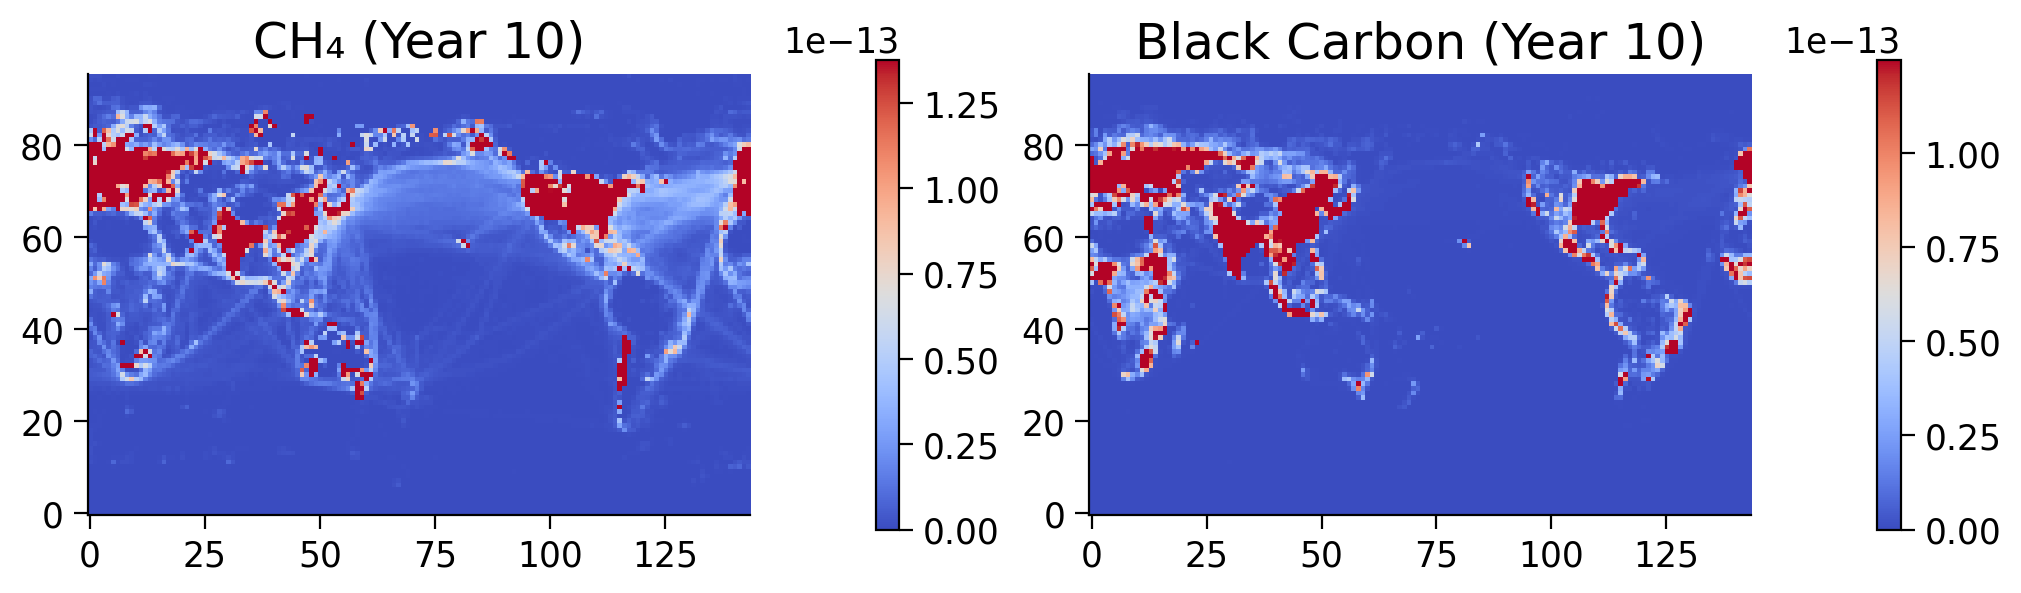

In [32]:
# @markdown Make sure you execute this cell to enable the widget!<br>
# @markdown * Click on the arrow Use the control buttons(`<`,`<<`,`>`,`>>`)  to anable the  animation
animate_climate_variables(X_train_torch, sample_idx=0, scale_mode='auto')  #May toggle scale_mode toscale_mode='auto'or scale_mode='log'

### Interpreting the Animation

This animation displays the spatial distribution of four climate variables (CO₂, CH₄, SO₂, Black Carbon) side by side over a 10-year sequence. Each panel corresponds to one variable, and the colors represent its relative concentration across the globe for each year. As the animation progresses, you can observe how the spatial patterns of each variable evolve over time.

### How to use the animation
Use the control buttons(`<`,`<<`,`>`,`>>`) given to start the animation.

Simply watch the animation. It automatically cycles through the 10-year period, updating all four panels simultaneously. Focus on how patterns change across years and compare differences between variables. No manual interaction is required.


In [33]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_5")

# Section 6: Defining the CNN-LSTM Model Architecture

🚀 **Next Step:** Moving to Defining the CNN-LSTM Model Architecture!

The Challenge: Modeling Spatiotemporal Climate Data
Climate data exhibits both **spatial patterns** (e.g., temperature distributions) and **temporal dependencies** (e.g., seasonal trends). Standard deep learning models struggle to effectively capture both aspects.

To overcome this, we use a **hybrid CNN-LSTM architecture**, which is **specially designed** to process spatiotemporal data.

---



## Section 6.1 Understanding the CNN-LSTM Hybrid Model

The CNN-LSTM model integrates two powerful deep learning components:

1. Convolutional Neural Networks (CNNs): Extracting Spatial Features
- CNNs are highly effective at recognizing spatial structures in images.
- Here, CNNs are applied **independently at each time step** to extract spatial patterns from climate data.
- This ensures that each time step has a structured representation before moving forward in the model.

2. Long Short-Term Memory Networks (LSTMs): Capturing Temporal Dependencies
- LSTMs are specialized for handling **sequential data**, such as time series.
- After spatial features are extracted by CNNs, the LSTM learns **how these features evolve over time**.
- This enables the model to understand long-term climate trends.

---

**Model Workflow: Step-by-Step**  
1️⃣ **Input Data:** Climate data is structured as a sequence of frames, where each frame represents a climate variable snapshot.  
2️⃣ **CNN Feature Extraction:** A CNN is applied to **each time step** to extract spatial features.  
3️⃣ **Time-Distributed Processing:** The CNN operates in a **Time Distributed** manner, ensuring spatial features remain distinct at each time step.  
4️⃣ **LSTM Sequence Learning:** The extracted spatial features are passed into an LSTM, which captures **temporal dependencies**.  
5️⃣ **Prediction Output:** The model predicts climate variables for the next time step, enabling forecasting.  

---

###  **Why Use Time-Distributed Layers?**
🔹 Without a **Time-Distributed Layer**, CNNs would treat the entire sequence as a single image, losing temporal information.  
🔹 With **Time-Distributed CNN**, spatial features are extracted **independently at each time step** before entering the LSTM.  
🔹 This preserves both spatial and temporal relationships, leading to **better climate forecasting accuracy**.

📖 **Further Reading:**  
👉 [Understanding Time-Distributed Layers in Deep Learning](https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00)

---



## Section 6.2 Implementing the CNN-LSTM Model in PyTorch


Before diving into the code, let’s understand its structure and the tools we will use.

**What Are We Doing?**

We are implementing the CNN-LSTM architecture using PyTorch, which will:
- **Extract spatial features** from climate data using CNN layers.
- **Preserve time-step independence** with Time-Distributed layers.
- **Model sequential dependencies** using an LSTM.
- **Output a structured climate forecast**.

**Why Use PyTorch?**

PyTorch provides:
- **Flexibility**: Easy debugging and dynamic computation graphs.
- **Modular Design**: Enables clean implementation of CNN and LSTM layers.
- **Efficient Computation**: Optimized tensor operations for large climate datasets.

**How Will We Implement This in Code ?**

We will define a PyTorch model that:
- Uses `nn.Conv2d` for spatial feature extraction.
- Applies **Time-Distributed processing** using reshaping techniques.
- Employs `nn.LSTM` for capturing temporal dependencies.
- Outputs climate forecasts using `nn.Linear` and `nn.Reshape`.

<details>
<summary> <font color='lightGreen'>Recap Key PyTorch Functions and Methods to be Used in the Next code cell </font></summary>

 **Recap Key PyTorch Functions and Methods to be Used in the Next code cell**

| **Component**         | **PyTorch Function**              | **Purpose**                                   |
|----------------------|--------------------------------|---------------------------------------------|
| **CNN Layer**       | `nn.Conv2d()`                   | Extracts spatial features                   |
| **Pooling Layer**   | `nn.AvgPool2d()`                | Reduces spatial dimensions                  |
| **Flattening**      | `torch.flatten()`               | Prepares data for LSTM input                |
| **LSTM Layer**      | `nn.LSTM()`                     | Captures temporal dependencies              |
| **Fully Connected** | `nn.Linear()`                   | Outputs predictions                         |
| **Activation**      | `nn.ReLU()`, `nn.Linear()`      | Introduces non-linearity, maps predictions  |
</details>

With this understanding, let’s now define the model!


In [34]:
class TimeDistributed(nn.Module):
    """
    A wrapper to apply a given module independently to each time step.
    This is useful for processing sequential climate data with CNN layers.
    """

    def __init__(self, module):
        """
        Initializes the TimeDistributed wrapper.

        Args:
        module (nn.Module): The neural network layer (e.g., Conv2D, Pooling)
                            to be applied across time steps.
        """
        super(TimeDistributed, self).__init__()
        self.module = module  # Store the provided module

    def forward(self, x):
        """
        Forward pass that applies the module independently across time steps.

        Args:
        x (tensor): Input of shape (batch_size, time_steps, channels, height, width).

        Returns:
        tensor: Output tensor with the same time dimension preserved.
        """
        batch_size, time_steps = x.size(0), x.size(1)  # Extract batch and time steps
        input_size = tuple(x.size()[2:])  # Get spatial dimensions (C, H, W)

        # Flatten time steps into the batch dimension for independent processing
        x = x.contiguous().view(batch_size * time_steps, *input_size)

        # Apply the module (e.g., CNN) separately to each time step
        x = self.module(x)

        # Restore original (batch, time, ...) structure after processing
        output_size = tuple(x.size()[1:])  # Extract new feature dimensions
        return x.view(batch_size, time_steps, *output_size)

<details>
<summary> <font color='lightGreen'> Breaking Down the Code </font></summary>

 🔍 **Understanding the `TimeDistributed` Wrapper**  

Neural networks process data in a structured way, and PyTorch provides tools to make this easier. In sequence-based tasks, like climate forecasting, we often need to **apply the same neural network layer to each time step separately**. This is where the **`TimeDistributed` wrapper** comes in.  

Normally, CNNs process entire images at once, but in time-series tasks, we need CNNs to **extract features from each timestep independently** before passing them to an LSTM. The `TimeDistributed` class helps achieve this by **automatically applying CNNs or other layers to each time step separately** while keeping the time structure intact.  

**Step-by-Step Breakdown**  

🔹 **Defining the Class (`__init__()`)**  
- In Python, a **class** is like a **blueprint** for creating reusable components.  
- This class **inherits from `nn.Module`**, which is a standard PyTorch way to define neural network layers.  
- The `TimeDistributed` wrapper takes a **PyTorch layer (like `Conv2D`)** as input and ensures that it is applied **individually to each time step** in a sequence.  

🔹 **How Data Moves Through `forward()`**  
1️⃣ The **batch size and number of time steps** are extracted from the input tensor.  
2️⃣ The input is **reshaped** so that all timesteps are treated as separate images.  
3️⃣ The selected PyTorch **module (e.g., CNN)** is applied to the reshaped data.  
4️⃣ The output is then **reshaped back** into its original format, keeping time steps intact.  

✅ **Key Benefit**: This method allows CNNs to extract spatial features **without losing the sequence structure**, making it ready for LSTM processing.  

By combining **CNNs (for spatial feature extraction) and LSTMs (for temporal learning)**, we ensure that the model learns both **where** and **how** climate patterns change over time.   


### Section 6.2.1. Building the CNN-LSTM Model  
Now, we define the full **CNN-LSTM model**, integrating:  
- **`TimeDistributed CNN`** to extract spatial features per timestep.  
- **`LSTM`** to learn temporal patterns.  
- **`Fully Connected Layer`** to predict climate variables.  

**Key Components in The following  Code cell:**  
- **`TimeDistributed`**: Applies CNN layers independently to each timestep.  
- **`nn.LSTM`**: Captures long-term dependencies across timesteps.  
- **`nn.Linear`**: Maps LSTM outputs to climate predictions.  
- **Reshaping techniques**: Ensures correct data format before feeding into layers.  

### Section 6.2.2 Implementing TimeDistributed Wrapper
   
Before integrating CNN into our model, we define a **TimeDistributed wrapper** to ensure CNN processes each timestep separately.

<details>
<summary> <font color='lightGreen'>Understanding the `TimeDistributed` Wrapper</font></summary>
** Understanding the `TimeDistributed` Wrapper**

When working with **climate data**, each time step contains **spatial information** that must be processed separately before considering temporal dependencies. A CNN alone does not recognize time steps—it treats inputs as independent images. We need a way to **apply CNN layers individually at each time step** before passing the output to an LSTM.

---

 🏗 ***Why Do We Need `TimeDistributed`?****
❌ **Without `TimeDistributed`**:  
- A CNN would **see all time steps as one large image**, ignoring the temporal structure.

✅ **With `TimeDistributed`**:  
- The CNN applies its filters **individually** to each time step.
- This ensures the **spatial features are extracted separately** before temporal modeling.

---
</details>

Let's now define the model! 🚀  


In [35]:
# --- Define helper modules ---
class TimeDistributed(nn.Module):
    """
    A wrapper to apply a given module independently to each time step.
    This is useful for processing sequential climate data with CNN layers.
    """

    def __init__(self, module):
        """
        Initializes the TimeDistributed wrapper.

        Args:
        module (nn.Module): The neural network layer (e.g., Conv2D, Pooling)
                            to be applied across time steps.
        """
        super(TimeDistributed, self).__init__()
        self.module = module  # Store the provided module

    def forward(self, x):
        """
        Forward pass that applies the module independently across time steps.

        Args:
        x (tensor): Input of shape (batch_size, time_steps, channels, height, width).

        Returns:
        tensor: Output tensor with the same time dimension preserved.
        """
        batch_size, time_steps = x.size(0), x.size(1)  # Extract batch and time steps
        input_size = tuple(x.size()[2:])  # Get spatial dimensions (C, H, W)

        # Flatten time steps into the batch dimension for independent processing
        x = x.contiguous().view(batch_size * time_steps, *input_size)

        # Apply the module (e.g., CNN) separately to each time step
        x = self.module(x)

        # Restore original (batch, time, ...) structure after processing
        output_size = tuple(x.size()[1:])  # Extract new feature dimensions
        return x.view(batch_size, time_steps, *output_size)



class ReshapeLayer(nn.Module):
    """
    Custom PyTorch layer to reshape a tensor into a structured spatial format.
    Ensures the model outputs a climate prediction grid of shape (batch, 1, height, width).
    """
    def __init__(self, shape):
        """
        Initializes the reshape layer.

        Args:
        shape (tuple): The target shape (excluding batch size), e.g., (1, 96, 144).
        """
        super().__init__()
        self.shape = shape  # Store the target shape for reshaping

    def forward(self, x):
        """
        Defines the forward pass for reshaping.

        Args:
        x (tensor): The input tensor of shape (batch, features).

        Returns:
        tensor: Reshaped tensor with dimensions (batch, 1, height, width).
        """
        return x.view(-1, *self.shape)  # Reshape while preserving batch size


### Coding Exercise 6.2.2: Implementing the forward pass of CNN_LSTM model, which is designed for spatiotemporal climate forecasting.


In this exercise, you'll implement the complete `forward` method of the `CNN_LSTM` model for spatiotemporal climate forecasting.

This model:
- Applies CNN layers independently to each timestep using `TimeDistributed` wrappers.
- Uses an LSTM to capture temporal dependencies from the CNN-extracted spatial features.
- Applies a fully connected (linear) layer to project the LSTM output to a spatial climate grid.
- Reshapes the output to a 2D spatial prediction map of shape `(1, 96, 144)` per batch.

You will use the following layers in the same order:
1. `self.time_distributed_conv` - for convolution over time-distributed spatial input.
2. `self.time_distributed_pool` - for reducing spatial resolution.
3. `self.time_distributed_global_pool` - for compressing feature maps to size (1,1).
4. `squeeze` - to remove redundant spatial dimensions after pooling.
5. `self.lstm` - to process the sequence of CNN features.
6. `self.fc` - to map to the flattened spatial map (96x144).
7. `self.reshape` - to reshape the output to (batch, 1, 96, 144).

📌 **Input shape:** `(batch, timesteps, channels, height, width)`  
📌 **Expected output shape:** `(batch, 1, 96, 144)`
🟨 2. Exercise Code C

In [36]:
# --- Define the CNN-LSTM Model ---
class CNN_LSTM(nn.Module):
    """
    CNN-LSTM Model for spatiotemporal climate forecasting.

    - CNN (TimeDistributed) extracts spatial features per timestep.
    - LSTM captures temporal dependencies from CNN-extracted features.
    - Fully Connected Layer maps LSTM output to a climate prediction grid.
    """

    def __init__(self):
        """Initialize CNN-LSTM model layers."""
        super(CNN_LSTM, self).__init__()

        # CNN feature extraction applied to each timestep independently
        self.time_distributed_conv = TimeDistributed(nn.Conv2d(in_channels=4, out_channels=20, kernel_size=3, padding=1))
        self.time_distributed_pool = TimeDistributed(nn.AvgPool2d(2))  # Reduces spatial size
        self.time_distributed_global_pool = TimeDistributed(nn.AdaptiveAvgPool2d((1, 1)))  # Compresses feature maps

        # LSTM processes extracted spatial features across time
        self.lstm = nn.LSTM(input_size=20, hidden_size=25, batch_first=True)

        # Fully connected layer maps LSTM outputs to flattened spatial grid (96x144)
        self.fc = nn.Linear(25, 96 * 144)

        # Reshape layer formats output to match spatial map dimensions
        self.reshape = ReshapeLayer((1, 96, 144))

     # Specify the computations performed on the data
    def forward(self, x):
        """
        Defines forward pass for data flow through the CNN-LSTM model.

        Args:
          x (tensor): Input tensor of shape (batch, timesteps, channels, height, width)

        Returns:
          tensor: Output prediction map of shape (batch, 1, 96, 144)
        """
        batch_size, timesteps, C, H, W = x.size()

        #################################################
        ## TODO for students: complete the forward pass ##
        # 1. Apply TimeDistributed Conv2D layer to extract features from each timestep.
        # 2. Reduce the spatial dimensions using average pooling.
        # 3. Apply global average pooling to compress each feature map to size (1,1).
        # 4. Squeeze out the singleton spatial dimensions.
        # 5. Pass the resulting sequence of features to the LSTM.
        # 6. Use the last output of the LSTM.
        # 7. Project to flattened grid using the fully connected layer.
        # 8. Reshape the output to (batch, 1, 96, 144) spatial format.
        raise NotImplementedError("Student exercise: complete the CNN-LSTM forward pass")
        #################################################

        # Apply convolution over each timestep
        x = self.time_distributed_conv(...)  # <-- Replace ... with input tensor

        # Reduce spatial resolution
        x = self.time_distributed_pool(...)  # <-- Pass the result of previous layer

        # Compress feature maps to (1,1) spatial dimensions
        x = self.time_distributed_global_pool(...)  # <-- Pass the pooled output

        # Remove (1,1) spatial dimensions
        x = x.squeeze(-1).squeeze(-1)  # <-- Output now (batch, timesteps, features)

        # Process the sequence with LSTM
        r_out, (h_n, c_n) = self.lstm(...)  # <-- Feed squeezed output to LSTM

        # Use the final LSTM time step
        r_out = r_out[:, -1, :]  # <-- Take last timestep’s output

        # Map to spatial output
        x = self.fc(...)  # <-- Apply FC to final LSTM output

        # Reshape to final map
        x = self.reshape(...)  # <-- Reshape to (batch, 1, 96, 144)

        return x

In [37]:
# to_remove solution

# --- Define the CNN-LSTM Model ---
class CNN_LSTM(nn.Module):
    """
    CNN-LSTM Model for spatiotemporal climate forecasting.

    - CNN (TimeDistributed) extracts spatial features per timestep.
    - LSTM captures temporal dependencies from CNN-extracted features.
    - Fully Connected Layer maps LSTM output to a climate prediction grid.
    """

    def __init__(self):
        """Initialize CNN-LSTM model layers."""
        super(CNN_LSTM, self).__init__()

        # CNN feature extraction applied to each timestep independently
        self.time_distributed_conv = TimeDistributed(nn.Conv2d(in_channels=4, out_channels=20, kernel_size=3, padding=1))
        self.time_distributed_pool = TimeDistributed(nn.AvgPool2d(2))  # Reduces spatial size
        self.time_distributed_global_pool = TimeDistributed(nn.AdaptiveAvgPool2d((1, 1)))  # Compresses feature maps

        # LSTM processes extracted spatial features across time
        self.lstm = nn.LSTM(input_size=20, hidden_size=25, batch_first=True)

        # Fully connected layer maps LSTM outputs to flattened spatial grid (96x144)
        self.fc = nn.Linear(25, 96 * 144)

        # Reshape layer formats output to match spatial map dimensions
        self.reshape = ReshapeLayer((1, 96, 144))

     # Specify the computations performed on the data
    def forward(self, x):
        """
        Defines forward pass for data flow through the CNN-LSTM model.

        Args:
          x (tensor): Input tensor of shape (batch, timesteps, channels, height, width)

        Returns:
          tensor: Output prediction map of shape (batch, 1, 96, 144)
        """
        batch_size, timesteps, C, H, W = x.size()

        # Apply convolution over each timestep
        x = self.time_distributed_conv(x)

        # Reduce spatial resolution
        x = self.time_distributed_pool(x)

        # Compress feature maps to (1,1) spatial dimensions
        x = self.time_distributed_global_pool(x)

        # Remove (1,1) spatial dimensions
        x = x.squeeze(-1).squeeze(-1)  # Now (batch, timesteps, features)

        # Process the sequence with LSTM
        r_out, (h_n, c_n) = self.lstm(x)

        # Use the final LSTM time step
        r_out = r_out[:, -1, :]  # (batch, hidden_size)

        # Map to spatial output
        x = self.fc(r_out)  # (batch, 96*144)

        # Reshape to final map
        x = self.reshape(x)  # (batch, 1, 96, 144)

        return x

In [38]:
# test your solution

# Uncomment to test the output shape
#model = CNN_LSTM()  # Instantiate Model
# Generate random test input of shape (batch=2, timesteps=5, channels=4, height=32, width=48)
#x_test = torch.randn(2, 5, 4, 32, 48)
#output = model(x_test) # Run forward pass
# Check output shape
#print("Output shape:", output.shape)  # Should print: torch.Size([2, 1, 96, 144])

<details>
<summary> <font color='lightGreen'> Breaking Down the Code </font></summary>

 🔍 **Understanding the `CNN_LSTM` Model**  

Deep learning models in PyTorch are built using **classes that inherit from `nn.Module`**, which acts as a blueprint for defining and organizing model components. PyTorch provides a special method called `forward()`, which specifies how input data flows through the network. Instead of manually applying layers step by step, `forward()` ensures that the right computations happen in the correct order automatically.  

 **Step-by-Step Explanation of the Model**  

🔹 **Defining the Model (`__init__()`)**  
- We use **`TimeDistributed` CNN layers** to process each timestep independently. CNNs help extract spatial patterns, such as temperature or pressure variations in climate data.  
- **Pooling layers** (`AvgPool2d`, `AdaptiveAvgPool2d`) reduce the size of feature maps while keeping essential information, making the model efficient.  
- The **LSTM (`nn.LSTM`)** takes these features over time and learns how climate patterns evolve.  
- Finally, a **fully connected layer (`Linear`)** converts the LSTM outputs into a **climate forecast grid** for prediction.  

🔹 **How Data Flows Through the Model (`forward()`)**  
1️⃣ The input first moves through the **CNN layers** inside `TimeDistributed`, ensuring that each timestep is processed separately.  
2️⃣ The CNN output is **flattened**, meaning unnecessary spatial dimensions are removed, keeping only the most important information.  
3️⃣ This processed data is then passed to the **LSTM**, which learns how the extracted climate features change over time.  
4️⃣ The **last LSTM output** is selected because it contains the most useful information for prediction.  
5️⃣ Finally, the **fully connected layer** generates a numerical output, which is reshaped into a **spatial climate map**—a structured prediction of climate variables.  

By combining **CNNs (for spatial feature extraction)** and **LSTMs (for tracking changes over time)**, this model effectively learns both **where** and **how** climate patterns evolve.
</details>

### Section 6.2.4 Final Step: Instantiating and Checking Model
Before training, let’s instantiate our model and check its structure.

In [39]:
# Instantiate Model
model = CNN_LSTM()

# Print Model Summary
print(model)

CNN_LSTM(
  (time_distributed_conv): TimeDistributed(
    (module): Conv2d(4, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_distributed_pool): TimeDistributed(
    (module): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (time_distributed_global_pool): TimeDistributed(
    (module): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (lstm): LSTM(20, 25, batch_first=True)
  (fc): Linear(in_features=25, out_features=13824, bias=True)
  (reshape): ReshapeLayer()
)



🔎 What do you observe in the architecture?

The model follows a structured approach where CNN layers process spatial features independently for each time step before LSTMs capture temporal relationships. Notably, the use of `TimeDistributed` ensures that convolutional layers operate consistently across time, maintaining spatial integrity. The final fully connected layer acts as a bridge between the sequential features learned by the LSTM and the structured climate prediction output.

In [40]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_6")

---
# Section 7: Defining the Model, Loss Function, and Optimizer

With the training data ready, we now define the core components needed for model training:

- **The Model:** A CNN-LSTM hybrid to learn spatiotemporal climate patterns.
- **The Loss Function:** Measures how well the model predicts climate variables.
- **The Optimizer:** Updates model parameters to minimize error.

---
<details>
<summary> <font color='lightGreen'>Section 7.1 Defining the Model</font></summary>

## Section 7.1 Defining the Model

We initialize an instance of `CNN_LSTM`, which consists of:

1. **CNN Layers (TimeDistributed Conv2D):** Extracts spatial features from climate data at each time step.
2. **LSTM:** Captures long-term dependencies across time steps.
3. **Fully Connected Layer:** Maps LSTM outputs to the climate variable predictions.

---
</details>
<details>
<summary> <font color='lightGreen'>Section 7.2 Defining the Loss Function (Mean Squared Error)</font></summary>

## Section 7.2 Defining the Loss Function (Mean Squared Error)

We use **Mean Squared Error (MSE)** as our loss function:

$$
\mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{pred}, i} - y_{\text{true}, i})^2
$$

where:

- \( N \) is the number of grid points.
- \( y_{\text{pred}} \) is the model's predicted climate variable.
- \( y_{\text{true}} \) is the ground truth.
- The function **penalizes larger errors more strongly**, stabilizing model learning.

---
</details>
<details>
<summary> <font color='lightGreen'>Section 7.3 Defining the Optimizer (Adam Algorithm)</font></summary>

## Section 7.3 Defining the Optimizer (Adam Algorithm)

The **Adam optimizer** updates model parameters by computing adaptive learning rates for each weight:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

$$
\theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{v_t} + \epsilon} m_t
$$

where:

- \( g_t \) is the gradient at time \( t \).
- \( m_t \) and \( v_t \) are moving averages of gradients and squared gradients.
- \( \beta_1 = 0.9 \) and \( \beta_2 = 0.999 \) control momentum.
- \( \eta \) is the learning rate (set to **0.001**).
- **Advantages:** Adam adapts learning rates dynamically, making it robust for deep learning.


In [41]:
# 7. Define Model, Loss Function, and Optimizer

# Initialize the CNN-LSTM model
cnn_model = CNN_LSTM()
print(cnn_model)  # Display model architecture

# Define Mean Squared Error (MSE) Loss for regression-based climate prediction
criterion = nn.MSELoss()

# Adam optimizer with an adaptive learning rate (default β₁=0.9, β₂=0.999)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Print key components
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")

CNN_LSTM(
  (time_distributed_conv): TimeDistributed(
    (module): Conv2d(4, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_distributed_pool): TimeDistributed(
    (module): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (time_distributed_global_pool): TimeDistributed(
    (module): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (lstm): LSTM(20, 25, batch_first=True)
  (fc): Linear(in_features=25, out_features=13824, bias=True)
  (reshape): ReshapeLayer()
)
Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


We saw the **CNN-LSTM model** architecture, where a **TimeDistributed CNN** extracts spatial patterns, an **LSTM** captures temporal dependencies, and a **fully connected layer** reconstructs spatial grids.  

✔ **Loss Function:** MSE minimizes prediction errors by penalizing squared differences.  
✔ **Optimizer:** Adam ensures efficient training with adaptive learning rates:  

With these components defined, we can now train the model and evaluate its performance on climate data.


In [42]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_7")

# Section 8: Training Loop with Validation and Early Stopping

Now that we have defined our model, optimizer, and loss function, we are ready to train the network.
Training a deep learning model involves iterating over the dataset multiple times, adjusting the model's parameters to minimize error.
To ensure the model generalizes well to unseen data, we implement **validation** and **early stopping** during training.

---

## Section 8.1 Understanding the Training Process  

Each deep learning model is trained using a loop that performs the following steps:  

1. **Forward Pass** – The model processes the input and makes predictions.  
2. **Loss Computation** – The difference between predictions and actual values is calculated using a loss function.  
3. **Backward Pass (Backpropagation)** – The gradients of the loss function with respect to the model's parameters are computed.  
4. **Parameter Update** – The optimizer updates the model parameters using these gradients.  
5. **Validation** – After each training epoch, the model is evaluated on a separate validation set to check its generalization ability.  
6. **Early Stopping** – Training is stopped when the validation loss stops improving to prevent overfitting.  

---



## Section 8.2 Key Hyperparameters in Training  

- **Epochs**: The number of times the model goes through the entire training dataset.  
- **Batch Size**: Number of samples processed before the model's weights are updated.  
- **Learning Rate**: Determines how much the model’s weights are adjusted during each optimization step.  
- **Patience**: The number of epochs to wait before stopping if validation loss doesn't improve.  

---



## Section 8.3 Preparing for Training  

We first split the dataset into **training** and **validation** sets. This allows us to monitor the model’s performance on unseen data during training.
We also set up the optimizer and early stopping parameters.  


In [43]:
# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# Split into training and validation sets
batch_size = 16
train_size = int(0.8 * len(X_train_torch))
val_size = len(X_train_torch) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    torch.utils.data.TensorDataset(X_train_torch, Y_train_torch),
    [train_size, val_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

## Section 8.4 Training Loop with Early Stopping  

The training loop processes the dataset in mini-batches. The model learns by computing gradients and updating parameters.
After each epoch, we evaluate the model on the validation set and apply early stopping.  

 Section : The Training Loop

Now, let's implement the core training loop. The loop performs the following steps:

1. **Set the model to training mode** – This ensures that certain layers (like dropout) behave correctly.
2. **Iterate through the training batches** – The model processes small subsets of data at a time.
3. **Compute predictions** – The model generates output for each input batch.
4. **Calculate the loss** – The difference between predicted and actual values is computed.
5. **Perform backpropagation** – Gradients are computed and used to update the model’s weights.
6. **Track validation performance** – After each epoch, the model is evaluated on the validation set.
7. **Apply early stopping** – Training stops if validation loss does not improve for a predefined number of epochs.

Let's implement this step by step.


### Coding Exercise 8.4: Training a CNN with weight and gradient tracking

Implement a PyTorch training loop for a CNN. Track the weights and gradients after every batch for analysis.

You are given: a model (`cnn_model`), loss function (`criterion`), optimizer, and data loaders. Your task:

- Run forward pass on batches
- Compute loss and backpropagate
- Update model weights
- Record weights and gradients each batch
- Compute training and validation losses per epoch
- Apply early stopping after `patience` epochs with no val improvement

**Hint**: Use `model.train()`, `optimizer.zero_grad()`, `loss.backward()`, and `optimizer.step()`.


In [44]:
def train_model(cnn_model, train_loader, val_loader, optimizer, criterion, num_epochs, patience):
    """Train a CNN model and store weights/gradients per batch

    Args:
        cnn_model (nn.Module): the model to train
        train_loader (DataLoader): dataloader for training data
        val_loader (DataLoader): dataloader for validation data
        optimizer (torch.optim.Optimizer): optimizer
        criterion (nn.Module): loss function
        num_epochs (int): total number of training epochs
        patience (int): early stopping patience

    Returns:
        tuple: (train_losses, val_losses, weights_history, grads_history)
    """

    #################################################
    # TODO:Implement the training loop with weight/gradient tracking
    # 1. Forward pass using X_batch
    # 2. Compute loss between predictions and targets
    # 3. Backpropagate and update weights
    # 4. Track weights and gradients for each batch
    # Fill remove the following line of code one you have completed the exercise:
    raise NotImplementedError("Student exercise: implement training loop with weight/grad tracking")
    #################################################

    # Initialize trackers for losses and history
    train_losses = []
    val_losses = []
    weights_history = []
    grads_history = []

    best_val_loss = float("inf")
    epochs_no_improve = 0

    print("Training Started!")
    for epoch in range(num_epochs):
        cnn_model.train()  # Set model to training mode
        train_loss = 0.0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            Y_pred = cnn_model(...)  # Forward pass-X_batch
            loss = criterion(...,...)  # Compute loss between Y_pred  Y_batch
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Accumulate batch loss
            train_loss += loss.item()

            # Store weights and gradients for each layer
            weights_history.append([p.clone().detach().cpu().numpy() for p in cnn_model.parameters()])
            grads_history.append([p.grad.clone().detach().cpu().numpy() for p in cnn_model.parameters() if p.grad is not None])

        # Compute average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        cnn_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                Y_val_pred = cnn_model(X_val)
                val_loss += criterion(Y_val_pred, Y_val).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}.")
            break

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    print("Training Complete!")
    return train_losses, val_losses, weights_history, grads_history

In [45]:
# to_remove solution
def train_model(cnn_model, train_loader, val_loader, optimizer, criterion, num_epochs, patience):
    """Train a CNN model and store weights/gradients per batch

    Args:
        cnn_model (nn.Module): the model to train
        train_loader (DataLoader): dataloader for training data
        val_loader (DataLoader): dataloader for validation data
        optimizer (torch.optim.Optimizer): optimizer
        criterion (nn.Module): loss function
        num_epochs (int): total number of training epochs
        patience (int): early stopping patience

    Returns:
        tuple: (train_losses, val_losses, weights_history, grads_history)
    """

    # Initialize trackers for losses and history
    train_losses = []
    val_losses = []
    weights_history = []
    grads_history = []

    best_val_loss = float("inf")
    epochs_no_improve = 0

    print("Training Started!")
    for epoch in range(num_epochs):
        cnn_model.train()  # Set model to training mode
        train_loss = 0.0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            Y_pred = cnn_model(X_batch)  # Forward pass-X_batch
            loss = criterion(Y_pred,Y_batch)  # Compute loss between Y_pred  Y_batch
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Accumulate batch loss
            train_loss += loss.item()

            # Store weights and gradients for each layer
            weights_history.append([p.clone().detach().cpu().numpy() for p in cnn_model.parameters()])
            grads_history.append([p.grad.clone().detach().cpu().numpy() for p in cnn_model.parameters() if p.grad is not None])

        # Compute average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        cnn_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                Y_val_pred = cnn_model(X_val)
                val_loss += criterion(Y_val_pred, Y_val).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}.")
            break

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    print("Training Complete!")
    return train_losses, val_losses, weights_history, grads_history

In [46]:
## Uncomment below to test your implementation
#train_losses, val_losses, weights_history, grads_history = train_model(
#     cnn_model, train_loader, val_loader, optimizer, criterion, num_epochs=1, patience=3
# )

> ⚠️ **Note:** Training will take some time depending on the number of epochs.  
> 💡 Run the traning and in the meantime, you can explore the remaining sections of the tutorial.


In [47]:
#call the training function
train_losses, val_losses, weights_history, grads_history = train_model(
    cnn_model, train_loader, val_loader, optimizer, criterion, num_epochs=1,patience=3
) #Please chnage the number of epcoh to atleast 30
#Play with more number of epochs/patience, if you want to improve the performance, just that it may take longer to run

Training Started!
Epoch 1 | Train Loss: 0.4303 | Val Loss: 0.4919
Training Complete!


### Loss Trend

Does the loss go down as training continues?📉

> In the above code cell where `train_model` is called, set `num_epochs = 30`.

If loss still does not decrease,one of the  possible reasong could be :
- The dataset may be too small

Before training, go to **Section 2.1 – Data Retrieval** and from the drop down select:
- All Climate Scenarios
- All Input Variables

Then run the remaing notebook again and watch the loss.


<details>
<summary> <font color='lightGreen'>Explanation:</font></summary>

**Explanation:**

*   **`cnn_model.train()`:** This line sets the model to training mode. This is important because some layers (like dropout) behave differently during training and evaluation.
*   **Inner loop:** The inner loop iterates over the training data in batches.
*   **`optimizer.zero_grad()`:** This line clears the gradients from the previous iteration. PyTorch accumulates gradients, so we need to clear them before calculating the gradients for the current iteration.
*   **`outputs = cnn_model(inputs)`:** This line performs the forward pass, feeding the input data through the model to obtain the predictions.
*   **`loss = criterion(outputs, targets)`:** This line calculates the loss between the predictions and the true values.
*   **`loss.backward()`:** This line performs the backward pass, calculating the gradients of the loss function with respect to the model's parameters.
*   **`optimizer.step()`:** This line updates the model's parameters using the calculated gradients.
*   **`cnn_model.eval()`:** This line sets the model to evaluation mode. This is important because some layers (like dropout) behave differently during training and evaluation.
*   **`with torch.no_grad():`:** This block disables gradient calculation during validation. We don't need to calculate gradients during validation, so disabling them saves memory and computation time.
*   **Early Stopping:** Inside the validation loop, the code checks if the current validation loss is less than the best validation loss seen so far. If it is, the best validation loss is updated, the `epochs_no_improve` counter is reset, and the model's state is saved to disk. If the validation loss doesn't improve for `patience` epochs, the training loop is broken.
</details>

Now since we trained the model now letr's check the predictions and visualise them to how does the model actually  perform.


In [48]:
# @title Run this cell to activate Interactive widget {"run":"auto","vertical-output":true,"display-mode":"form"}
# Interactive Widgets
print("Use the widgets below to visualize different aspects of training!")
interact(plot_weight_gradients, epoch=IntSlider(min=0, max=len(weights_history)-1, step=1, value=0, description="Epoch"));

Use the widgets below to visualize different aspects of training!


interactive(children=(IntSlider(value=0, description='Epoch', max=7), Output()), _dom_classes=('widget-interac…

In [49]:
# @title Run this cell to activate Interactive widget {"run":"auto","display-mode":"form"}
# @markdown Sample Predictions Over Time (Slider)
interact(plot_predictions1, epoch=IntSlider(min=0, max=9, step=1, value=0, description="Sample"));

interactive(children=(IntSlider(value=0, description='Sample', max=9), Output()), _dom_classes=('widget-intera…

In [50]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_8")

# Section 9: Making Predictions and Visualizing Results

Now that we have trained our model, let's use it to make predictions and visualize the results.

## Section 9.1 Making Predictions

We can use the trained model to make predictions on new data. For example, we can predict the temperature for a future time period based on the historical data and projected emission scenarios.

In [51]:
#Example of prediction (using the training data for demonstration)
cnn_model.to(device)
cnn_model.eval()
with torch.no_grad():
    X_train_torch = X_train_torch.to(device)  # Move input data to the same device as model
    predicted_tas = cnn_model(X_train_torch[:5]).cpu().detach().numpy()  # Move output back to CPU for NumPy
print("Predictions recorded!")

Predictions recorded!


<details>
<summary> <font color='lightGreen'>Explanation: </font></summary>

**Explanation:**

This code snippet demonstrates how to make predictions using the trained model. It takes the first 5 sequences from the training data (`X_train_torch[:5]`) and feeds them into the model. The `.detach().numpy()` converts the PyTorch tensor to a NumPy array for easier manipulation and visualization.
</details>

**Important:** In a real-world scenario, you would use *new*, unseen data to evaluate the model's performance and make predictions.

## Section 9.2 Visualizing Results
Visualizing the model's predictions is crucial for understanding its performance and identifying potential issues. We can use libraries like `matplotlib` and `cartopy` to plot the predicted temperature and compare it to the actual temperature.

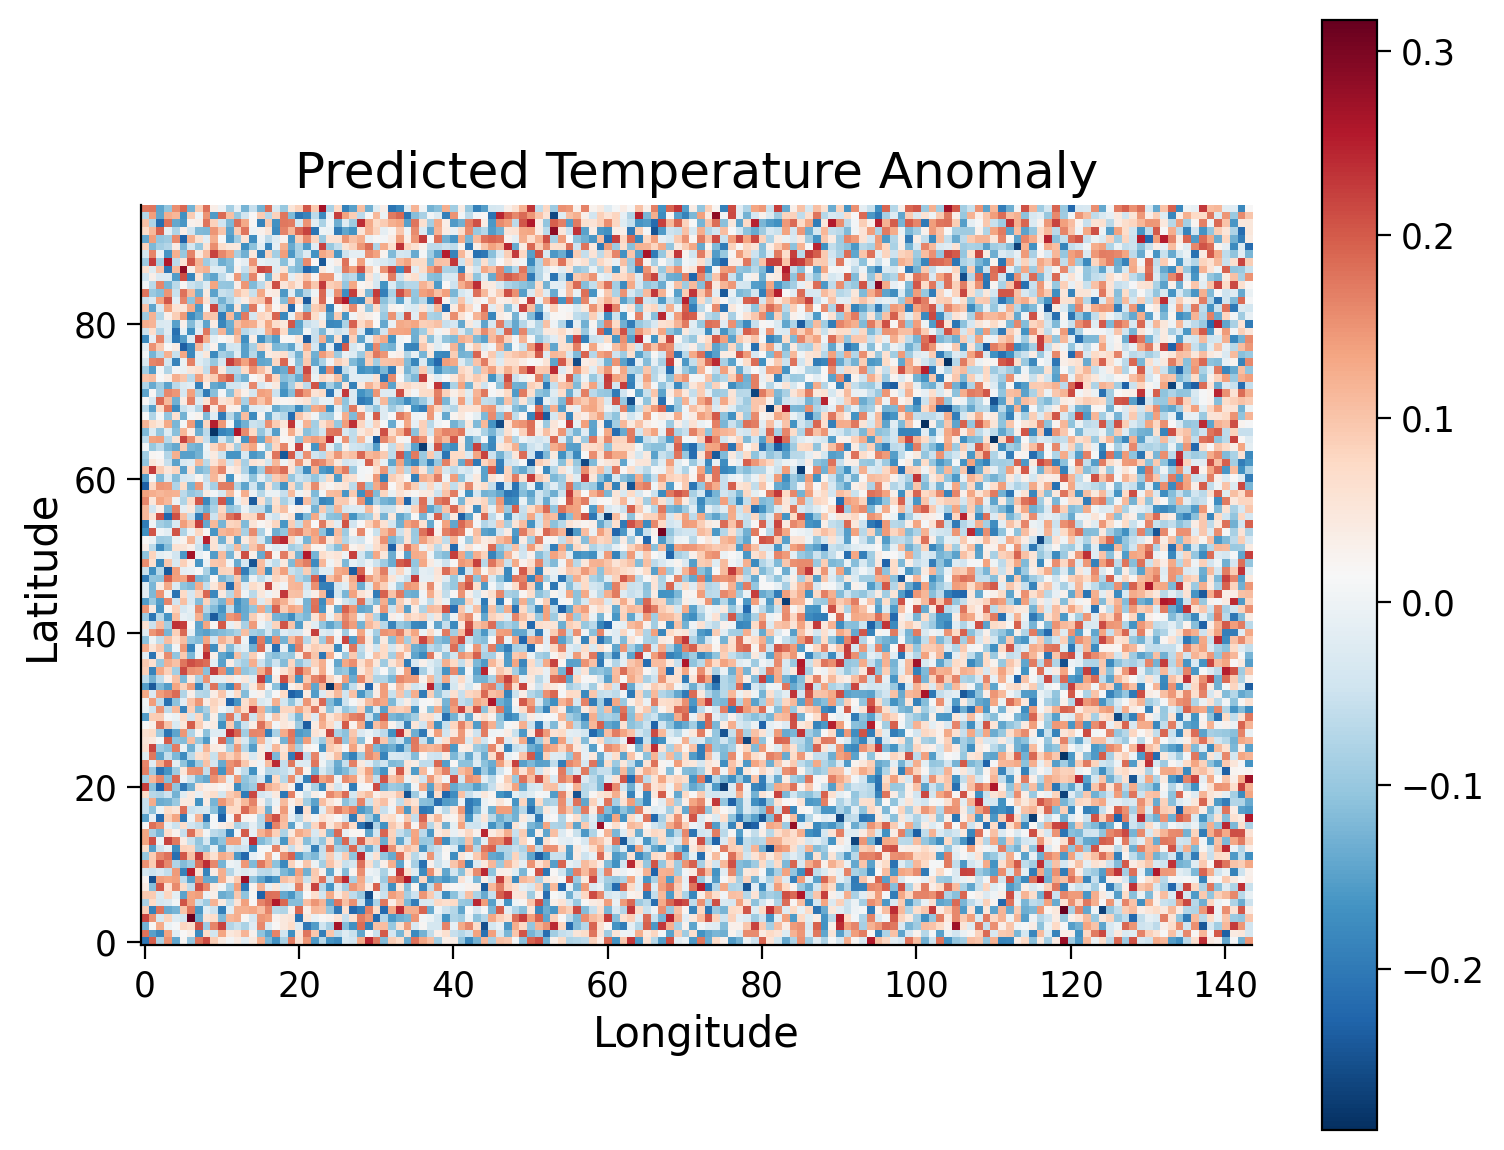

In [52]:
# @markdown Visualization example (plotting the first prediction)
plt.imshow(predicted_tas[0].squeeze(), origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Predicted Temperature Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<details>
<summary> <font color='lightGreen'>Explanation </font></summary>
**Explanation:**

This code uses `matplotlib.pyplot.imshow` to display the first predicted temperature map. `origin='lower'` ensures that the latitude increases from bottom to top in the plot. `cmap='RdBu_r'` sets the color map to a red-blue diverging colormap, which is commonly used for visualizing temperature anomalies. A colorbar is added to the plot to show the range of temperature values.

**Further Visualization Ideas:**

*   **Plotting actual vs. predicted temperatures:** Create scatter plots or time series plots to compare the model's predictions to the actual temperature values.
*   **Mapping the difference (error):** Plot the difference between the predicted and actual temperatures to visualize the model's errors.
*   **Using Cartopy for Geographic Projections:** Use `cartopy` to project the data onto a map, providing a more realistic view of the climate patterns.



**0. Using Cartopy for Geographic Projections**:

Use cartopy to project the data onto a map, providing a more realistic view of the climate patterns.

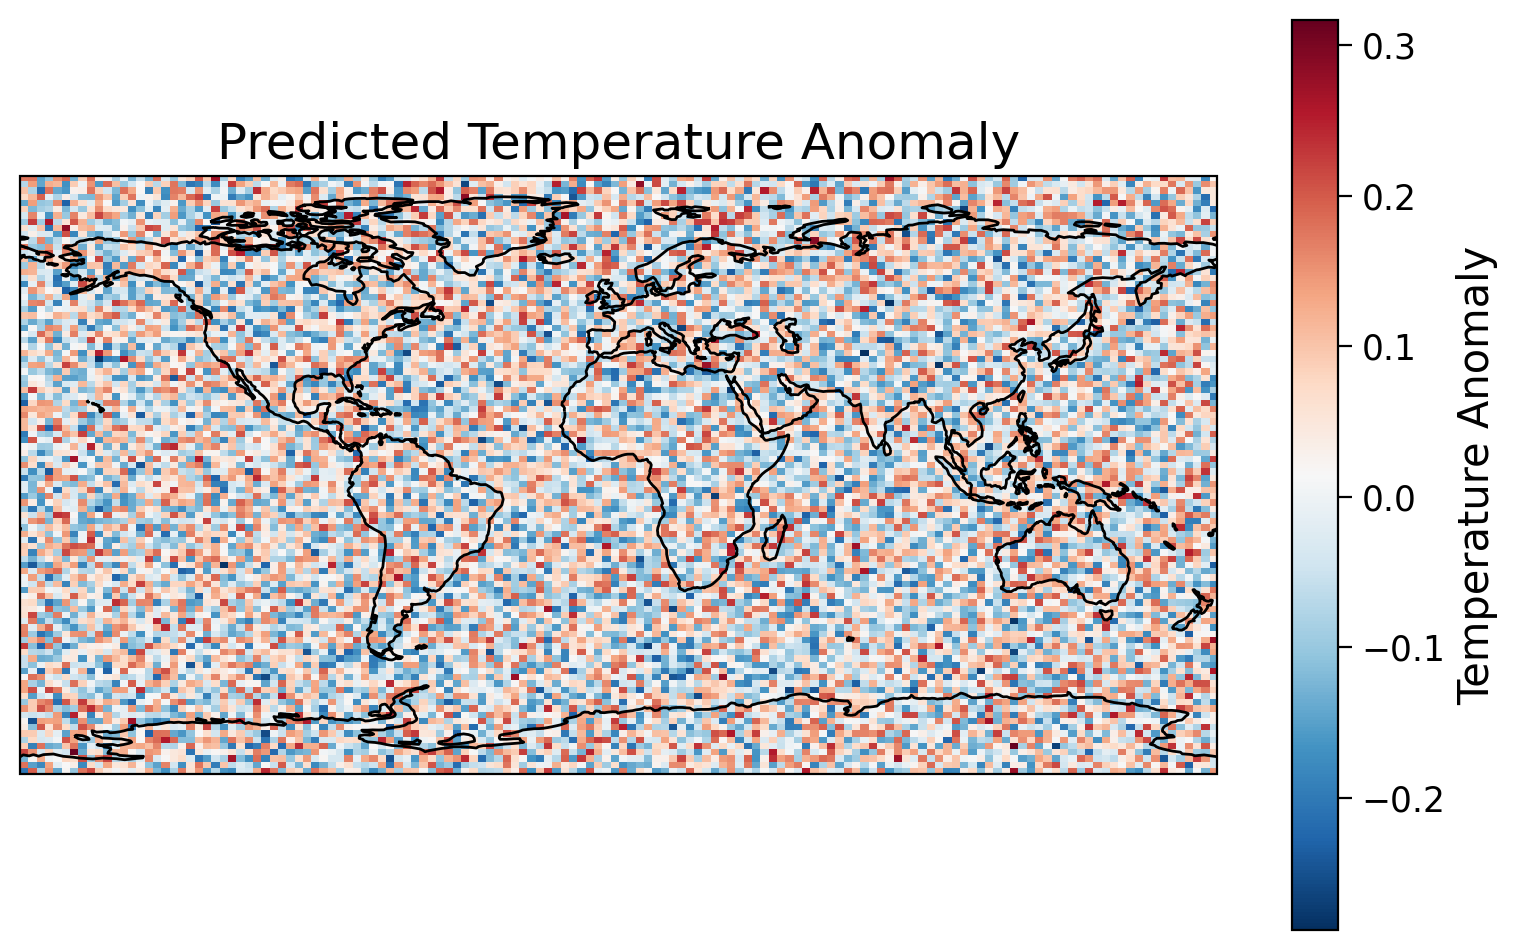

In [53]:
# @markdown Run this cell to view plot of `Predicted Temperature Anomaly`

# Set up the plot with a PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 5))
# Plot the predicted temperature anomaly
img = ax.imshow(predicted_tas[0].squeeze(), origin='lower', cmap='RdBu_r', extent=[-180, 180, -90, 90])
# Add coastlines for geographic context
ax.coastlines()
# Add a colorbar
plt.colorbar(img, ax=ax, orientation='vertical', label='Temperature Anomaly')
# Titles and labels
plt.title('Predicted Temperature Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**1 Difference (Error) Map**  
To see where the model deviates from the actual temperature.

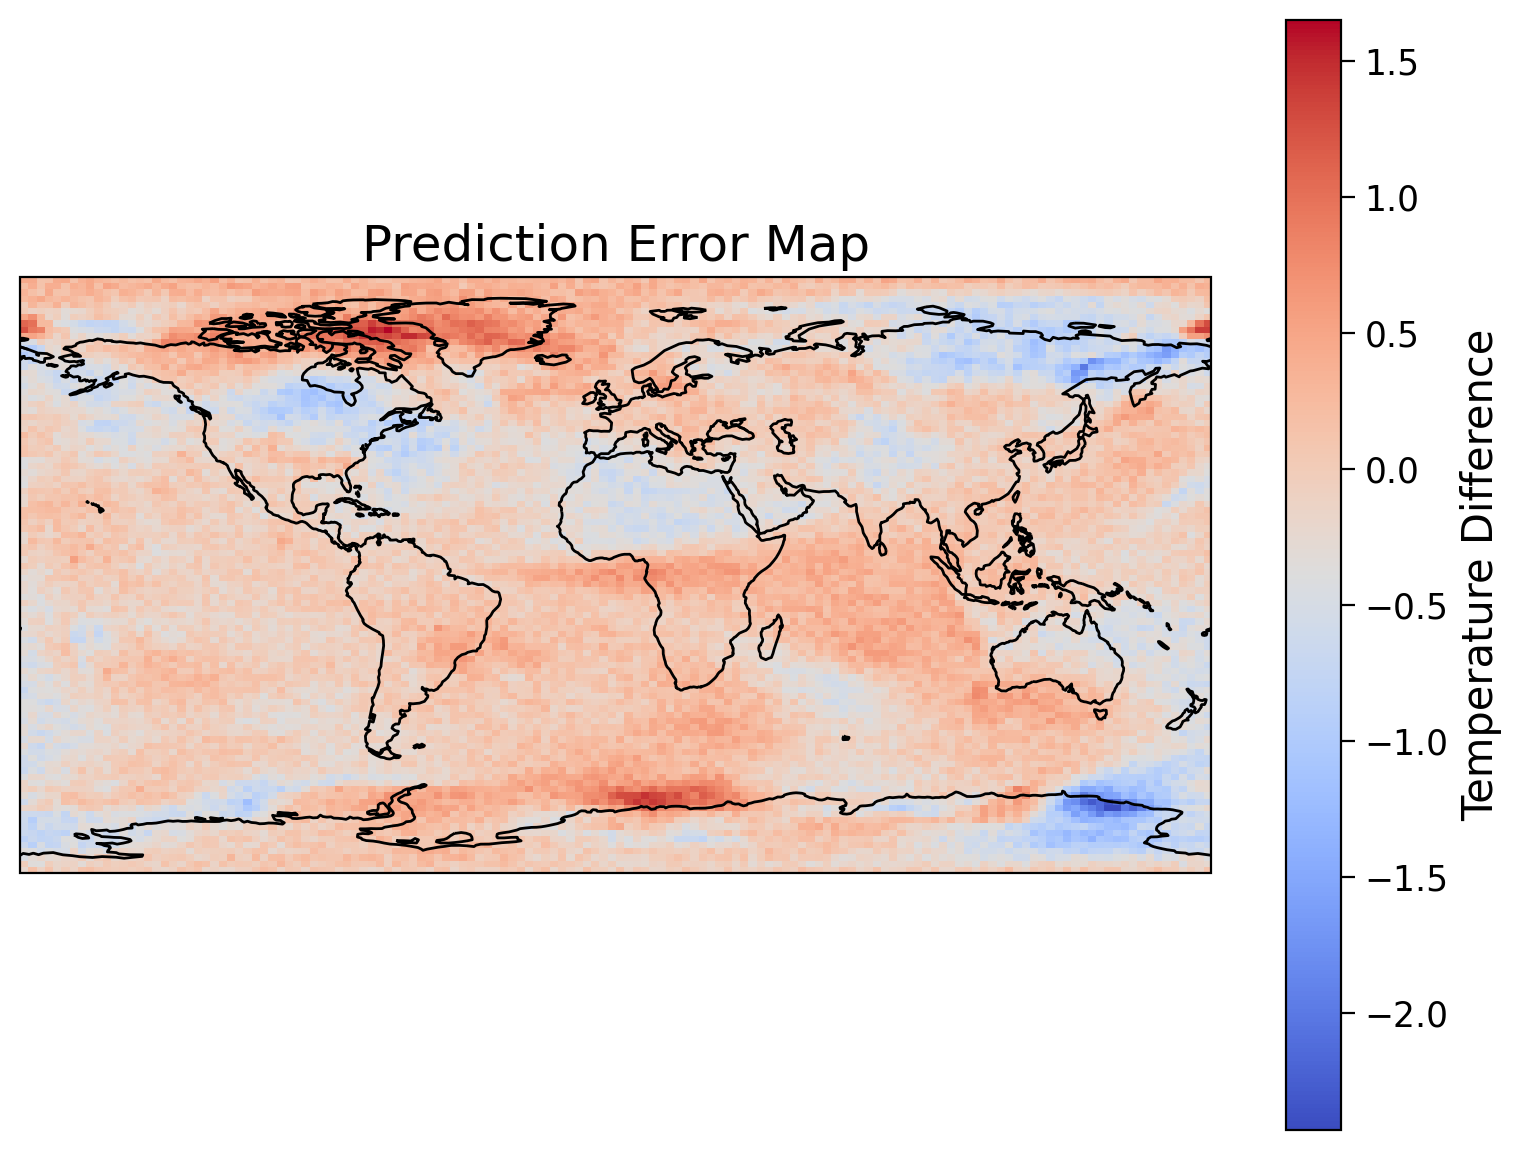

In [54]:
# @markdown Run this cell to visualise the Difference Map


actual_tas = Y_train_torch.cpu().numpy()  # Move to CPU and convert to NumPy if it's a tensor
# Compute error map between predicted and actual temperature anomalies
error_map = (predicted_tas[0, 0] - actual_tas[0]).squeeze()  # Ensure 2D shape

# Plot the difference map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
img = ax.imshow(error_map, origin='lower', cmap='coolwarm', extent=[-180, 180, -90, 90])

# Add coastlines and colorbar
ax.coastlines()
plt.colorbar(img, ax=ax, orientation='vertical', label="Temperature Difference")
plt.title("Prediction Error Map")
plt.show()

🔥 Insight: This highlights over- and under-predictions across the globe.

**2. Latitudinal Mean Temperature Profile**  
Check how temperature varies across latitude.

Shapes: (96,) (96,) (96,)


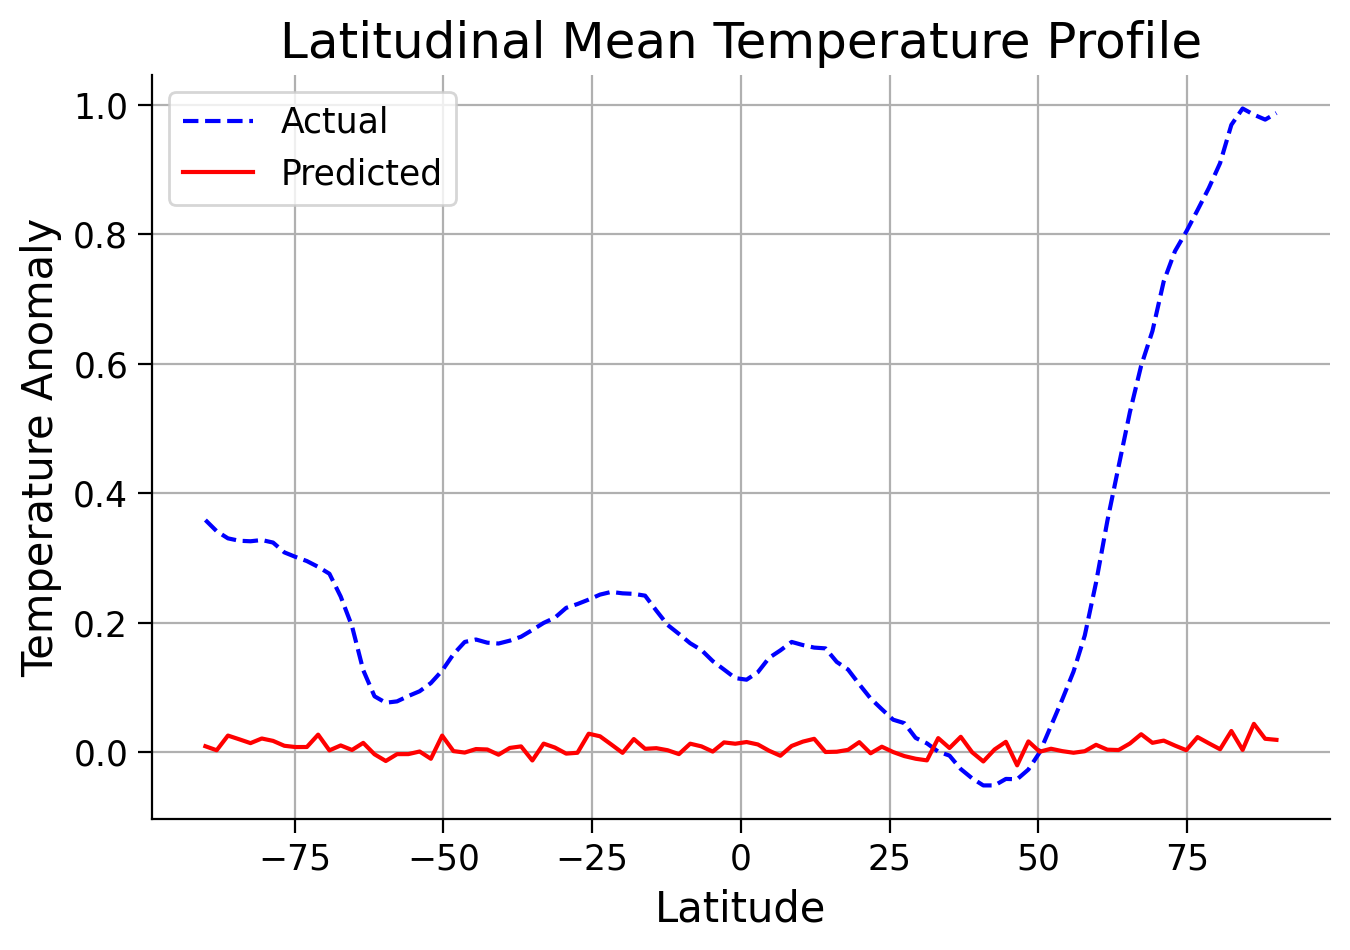

In [55]:
# @markdown Run this cell to visualise Latitudinal Mean Temperature Profile

# Compute zonal mean (average over longitudes)
predicted_lat_mean = np.mean(predicted_tas[0].squeeze(), axis=1)  # Shape: (96,)
actual_lat_mean = np.mean(actual_tas.squeeze(), axis=(0, 2))  # Ensure shape (96,)

# Generate latitude array
latitudes = np.linspace(-90, 90, predicted_lat_mean.shape[0])  # Shape: (96,)

# Ensure both arrays have the same shape
print("Shapes:", latitudes.shape, actual_lat_mean.shape, predicted_lat_mean.shape)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(latitudes, actual_lat_mean, label='Actual', linestyle='--', color='blue')
plt.plot(latitudes, predicted_lat_mean, label='Predicted', linestyle='-', color='red')
plt.xlabel('Latitude')
plt.ylabel('Temperature Anomaly')
plt.title('Latitudinal Mean Temperature Profile')
plt.legend()
plt.grid()
plt.show()

📈 Insight: Does the model capture temperature variations across latitudes accurately?

**3. Histogram of Prediction Errors**  
Assess model bias in temperature anomalies.

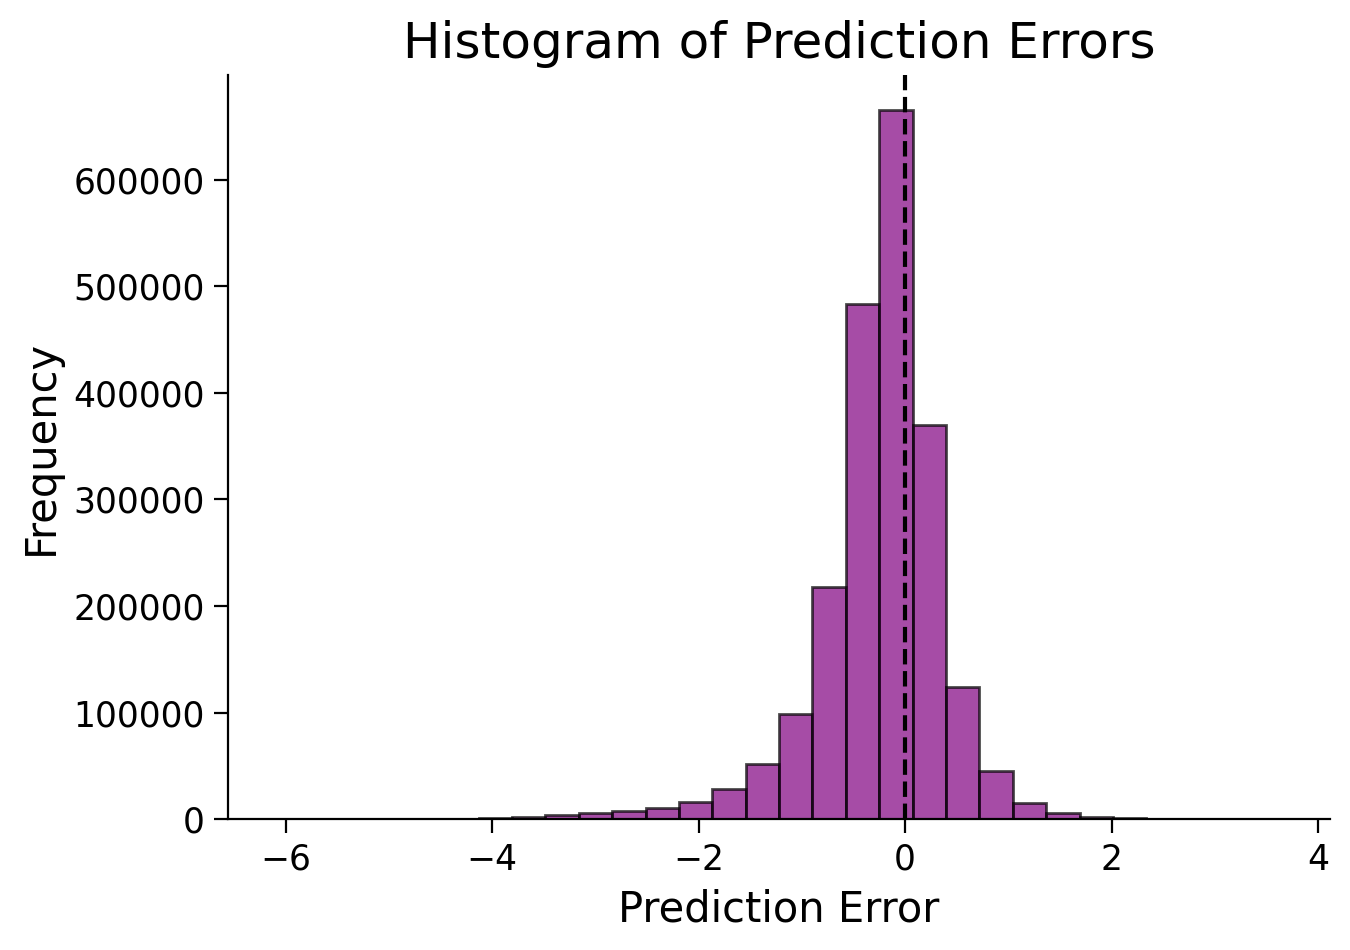

In [56]:
# @markdown Run this cell to visualise the Histogram of Prediction Errors

plt.figure(figsize=(7, 5))

# Flatten arrays and compute errors
errors = (predicted_tas[0].squeeze() - actual_tas).flatten()

plt.hist(errors, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='dashed')

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

📊 Insight: If errors are centered around 0, the model has no systematic bias.

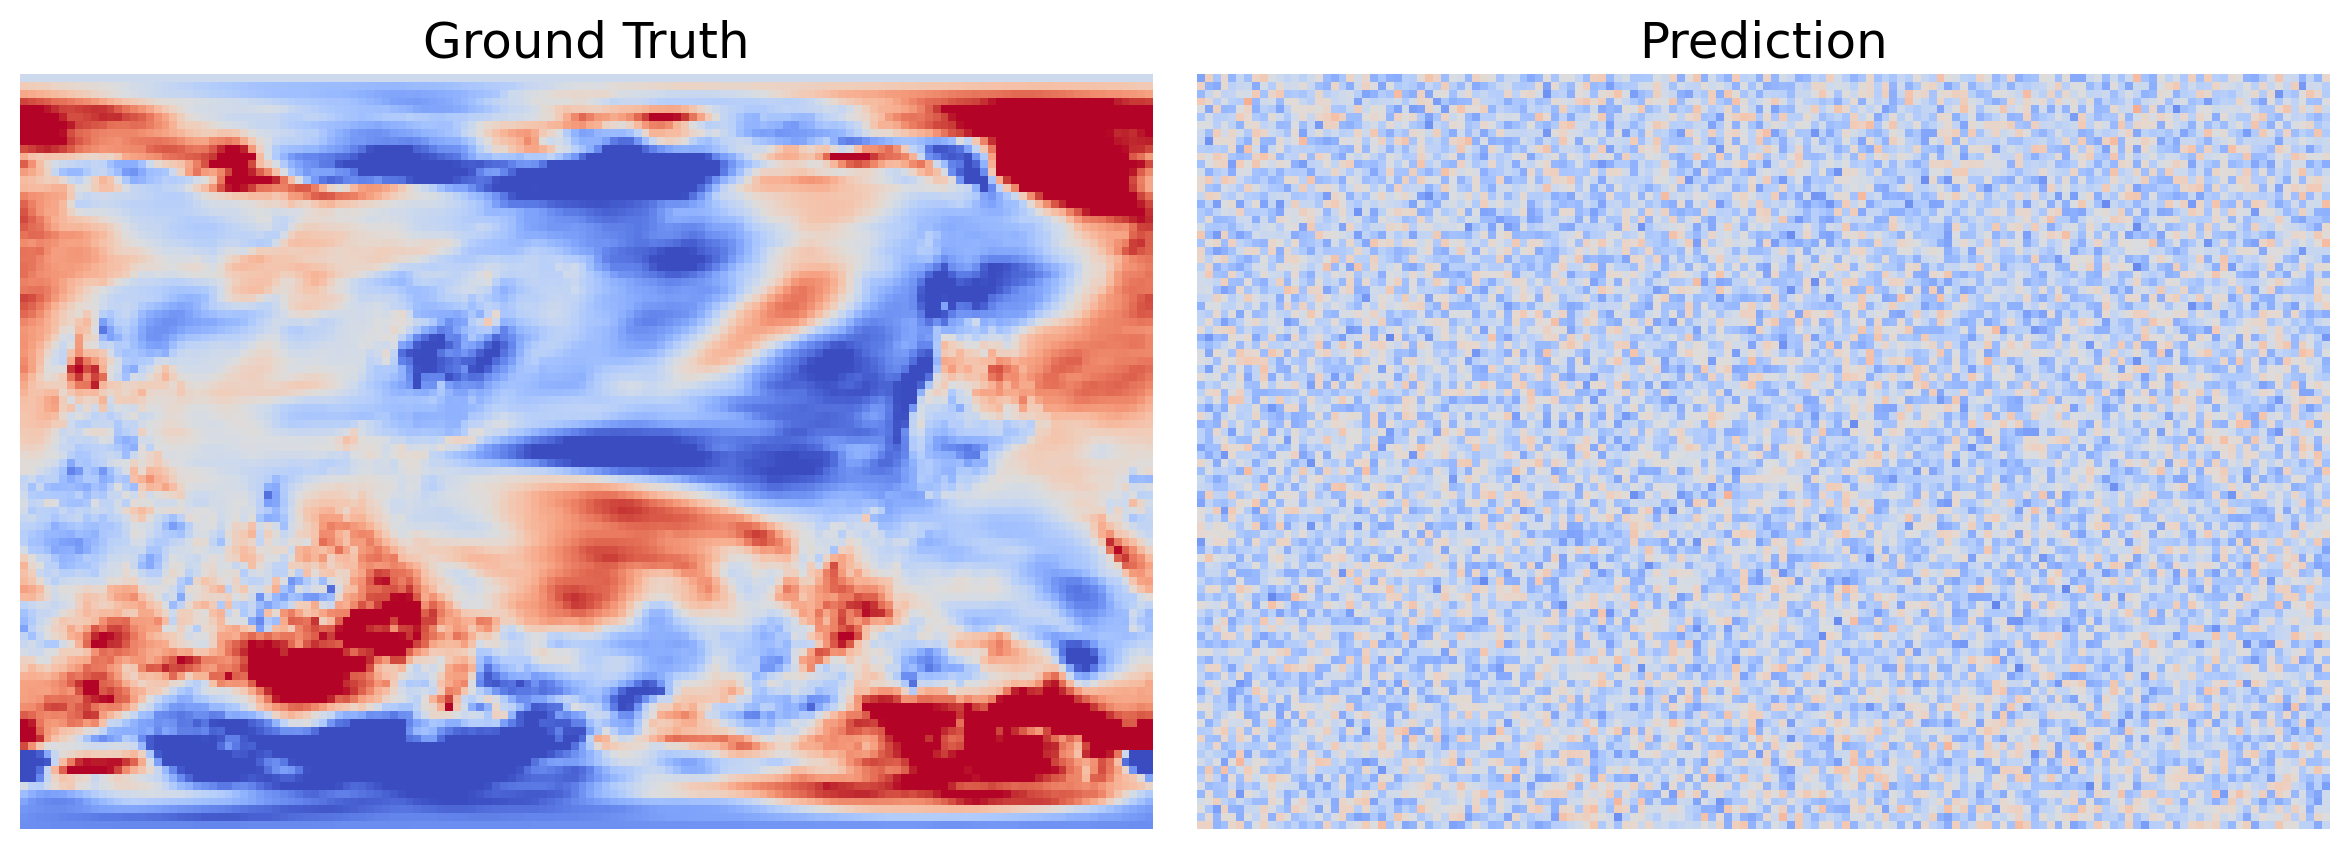

In [57]:
# @markdown 5. Prediction vs. Ground Truth Visualization
# Compares model predictions with actual data

#  usage (assuming model predictions are available)
sample_idx = 0  # Choose an index from your dataset (e.g., the first sample)
sample_input = X_train_torch[sample_idx].unsqueeze(0).to(device)  # Assuming X_train_torch holds your input data
y_pred_sample = cnn_model(sample_input).detach().cpu().numpy()
plot_predictions(Y_train_all[0], y_pred_sample, 'Model Prediction vs. Ground Truth')

**Noticed poor or vague predictions above?**
Follow these quick steps to improve them:

---

### 🔧 Improve Prediction & Visualization

**1. Select all scenarios**
In *Section 2.1.1*, choose **all climate scenarios**, then **rerun the notebook**.

> More data → better predictions.

**2. Set epochs ≥ 30**
In the training section, increase epochs to **at least 30**.

> Allows the model to learn better.

---

> Skipping these can lead to weak or misleading results.
> Try both steps and see the difference in plots and performance.

---


## Questions 9.2: How can we "trust" an emulator’s prediction?

In [58]:
#to_remove explanation
"""
Discussion: Visual similarity is intuitive, but quantitative metrics (e.g., RMSE, correlation) are needed to rigorously evaluate emulator quality.
Confidence also comes from generalization: does the emulator work on unseen scenarios?
Trust is built by balancing quantitative validation with domain understanding — knowing when small differences matter scientifically.
"""

'\nDiscussion: Visual similarity is intuitive, but quantitative metrics (e.g., RMSE, correlation) are needed to rigorously evaluate emulator quality.\nConfidence also comes from generalization: does the emulator work on unseen scenarios?\nTrust is built by balancing quantitative validation with domain understanding — knowing when small differences matter scientifically.\n'

In [59]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_9")

# Section 10 : Make final prediction on the Test Data from ClimateBench Repository



## Section 10.1 Make prediction for precipitation-related variables

In [60]:
# ==============================================
# Step 1: Load and Preprocess Test Data
# ==============================================

# Load test data from NetCDF files and compute values
download_test_data()

#Define the path to the test data
test_data_path = "Data/test/" 

X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            test_data_path + 'inputs_ssp245.nc']).compute()

# Normalize the selected variables using precomputed mean and standard deviation
for var in selected_climate_input_vars:
    var_dims = X_test[var].dims  # Get original dimensions of the variable
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))})  # Apply normalization

# Convert data to numpy format suitable for model input
X_test_np = input_for_training(X_test, skip_historical=False, len_historical=len_historical)

# Convert numpy array to PyTorch tensor and move to the appropriate device (CPU/GPU)
X_test_torch = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# Fix channel ordering: Move C to the third dimension (B, T, C, H, W)
X_test_torch = X_test_torch.permute(0, 1, 4, 2, 3)  # (B, T, C, H, W)


# ==============================================
# Step 2: Make Predictions Using Trained Model (safe version)
# ==============================================

cnn_model.to(device)
cnn_model.eval()

# Disable gradient computation
predictions = []

batch_size = 16  # Small batch size to prevent OOM

with torch.no_grad():
    for i in range(0, X_test_torch.shape[0], batch_size):
        batch = X_test_torch[i:i+batch_size].to(device)
        batch_pred = cnn_model(batch)
        predictions.append(batch_pred.cpu())

# Concatenate all batches
m_pred = torch.cat(predictions).numpy()

# ==============================================
# Step 3: Reformat Predictions to xarray Format
# ==============================================

# Reshape predictions to match spatial dimensions (latitude, longitude, time)
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])

# Convert to xarray DataArray with proper dimensions and coordinates
m_pred = xr.DataArray(
    m_pred,
    dims=['time', 'lat', 'lon'],
    coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data]
)

# Transpose the data for correct ordering and select relevant time range
m_pred = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015, 2101)).to_dataset(name=var_to_predict)

# Apply unit conversion for precipitation-related variables
if var_to_predict in ["pr90", "pr"]:
    m_pred = m_pred.assign({var_to_predict: m_pred[var_to_predict] / 86400})  # Convert from seconds to days

flag = 1  # Set to 1 if this cell runs successfully; otherwise, it remains 0. Used in the next cell to check wether to use dummy value or not.

print("Prediction m_pred is ")
m_pred

Prediction m_pred is 


<xarray.Dataset> Size: 5MB
Dimensions:  (time: 86, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (lat, lon, time) float32 5MB -0.1638 -0.1625 ... 0.275 0.2759

var_to_predict :  tas


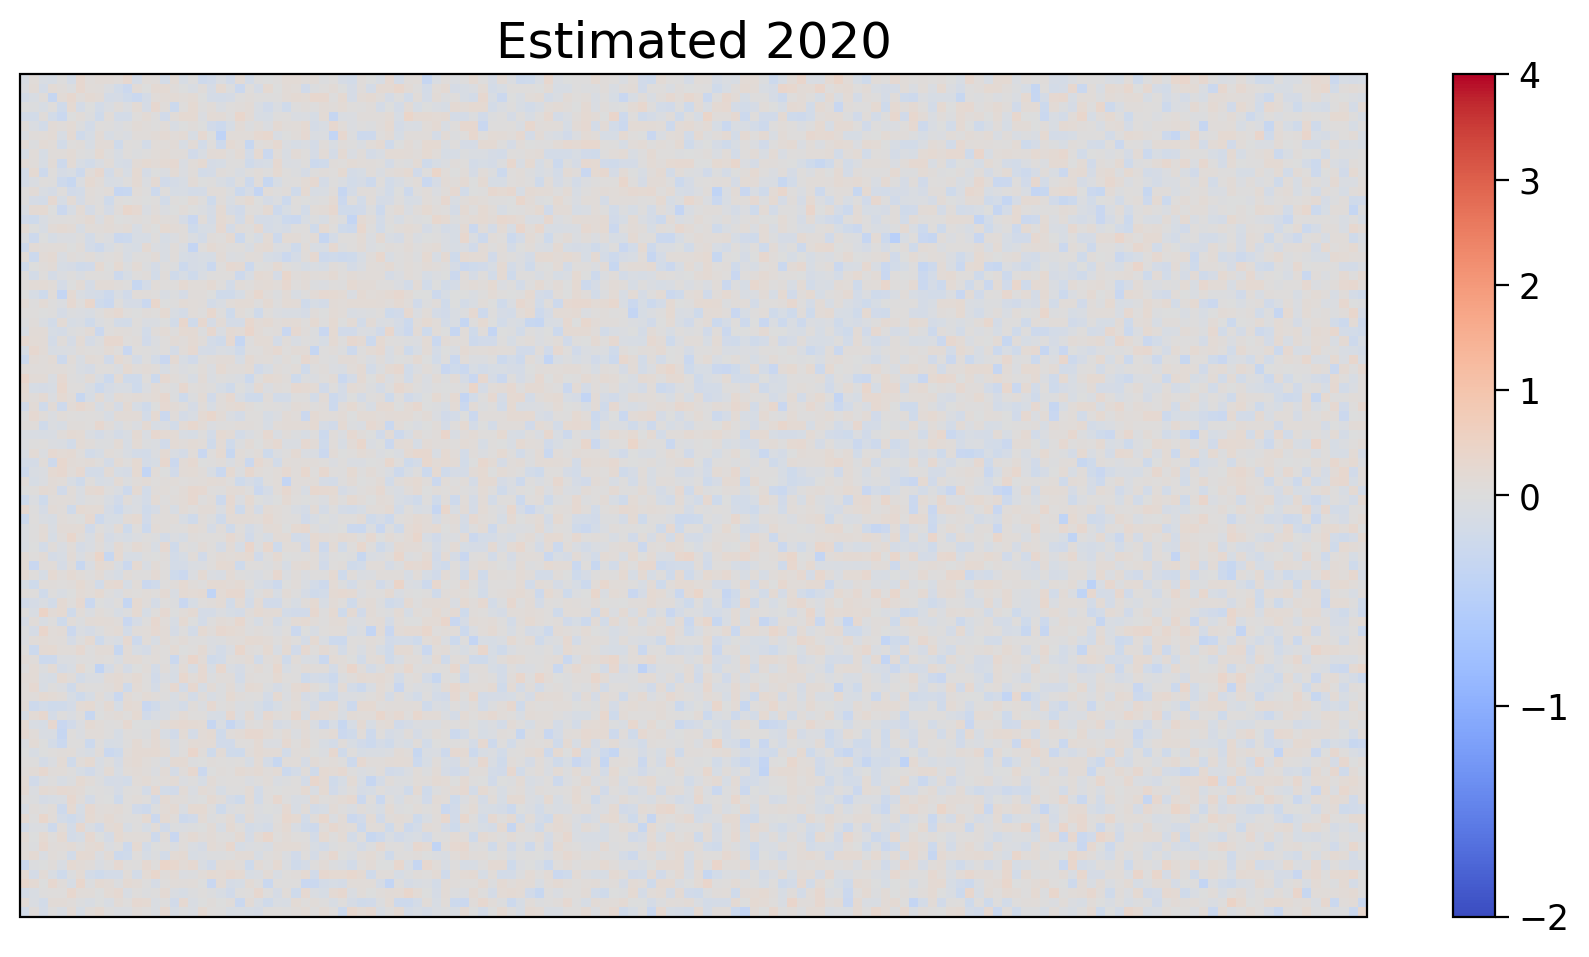

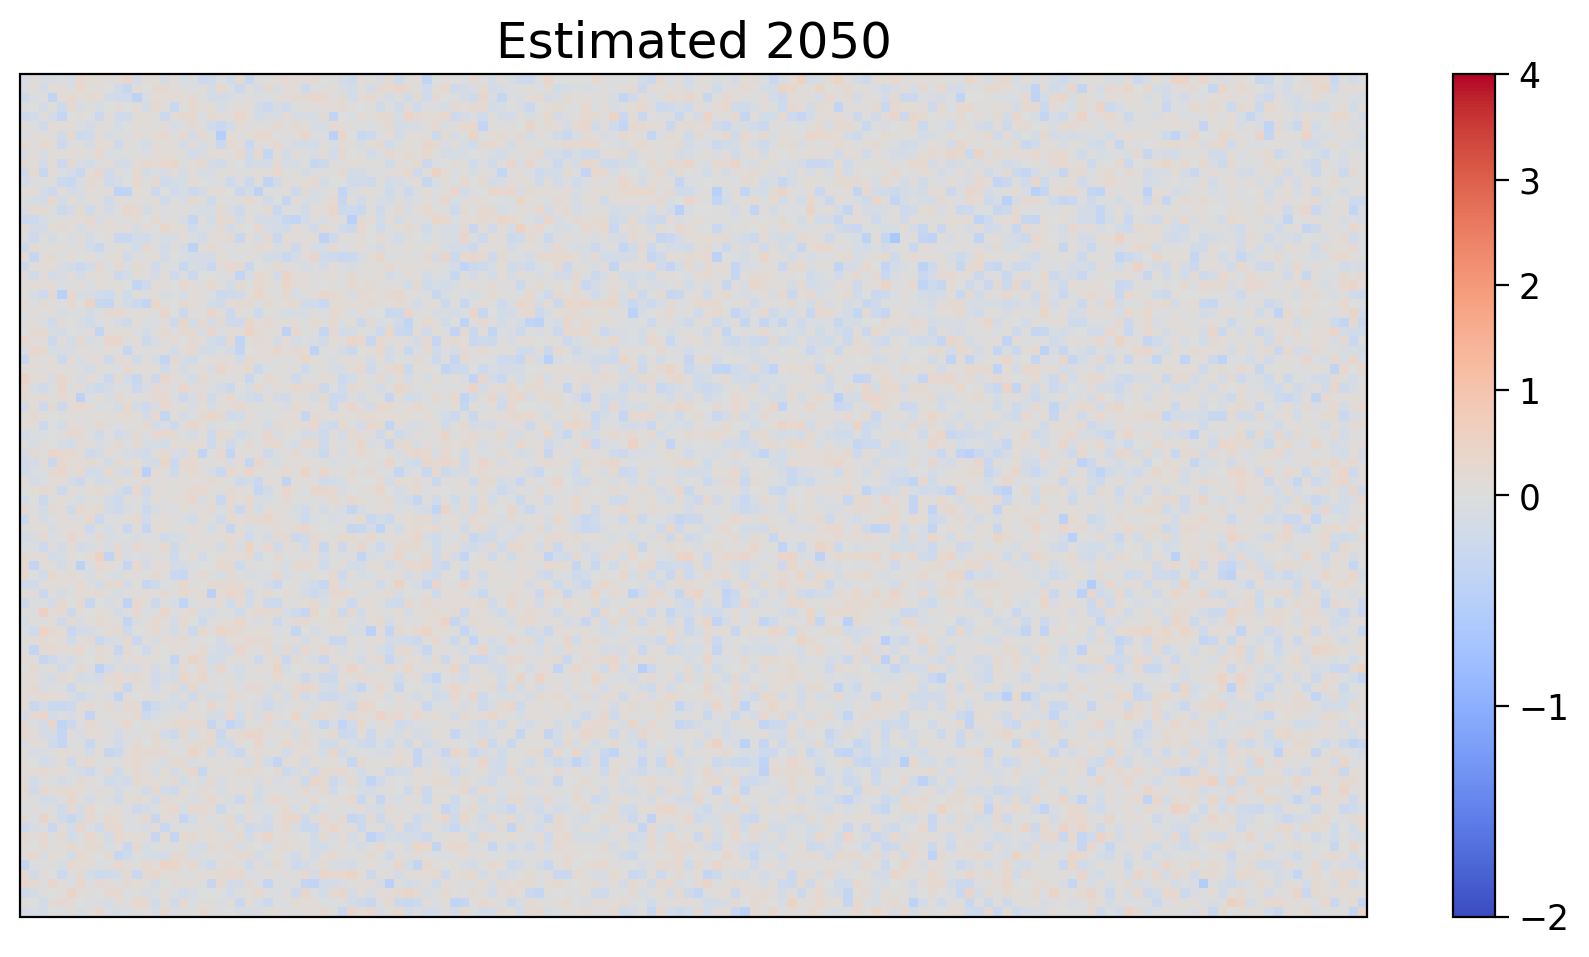

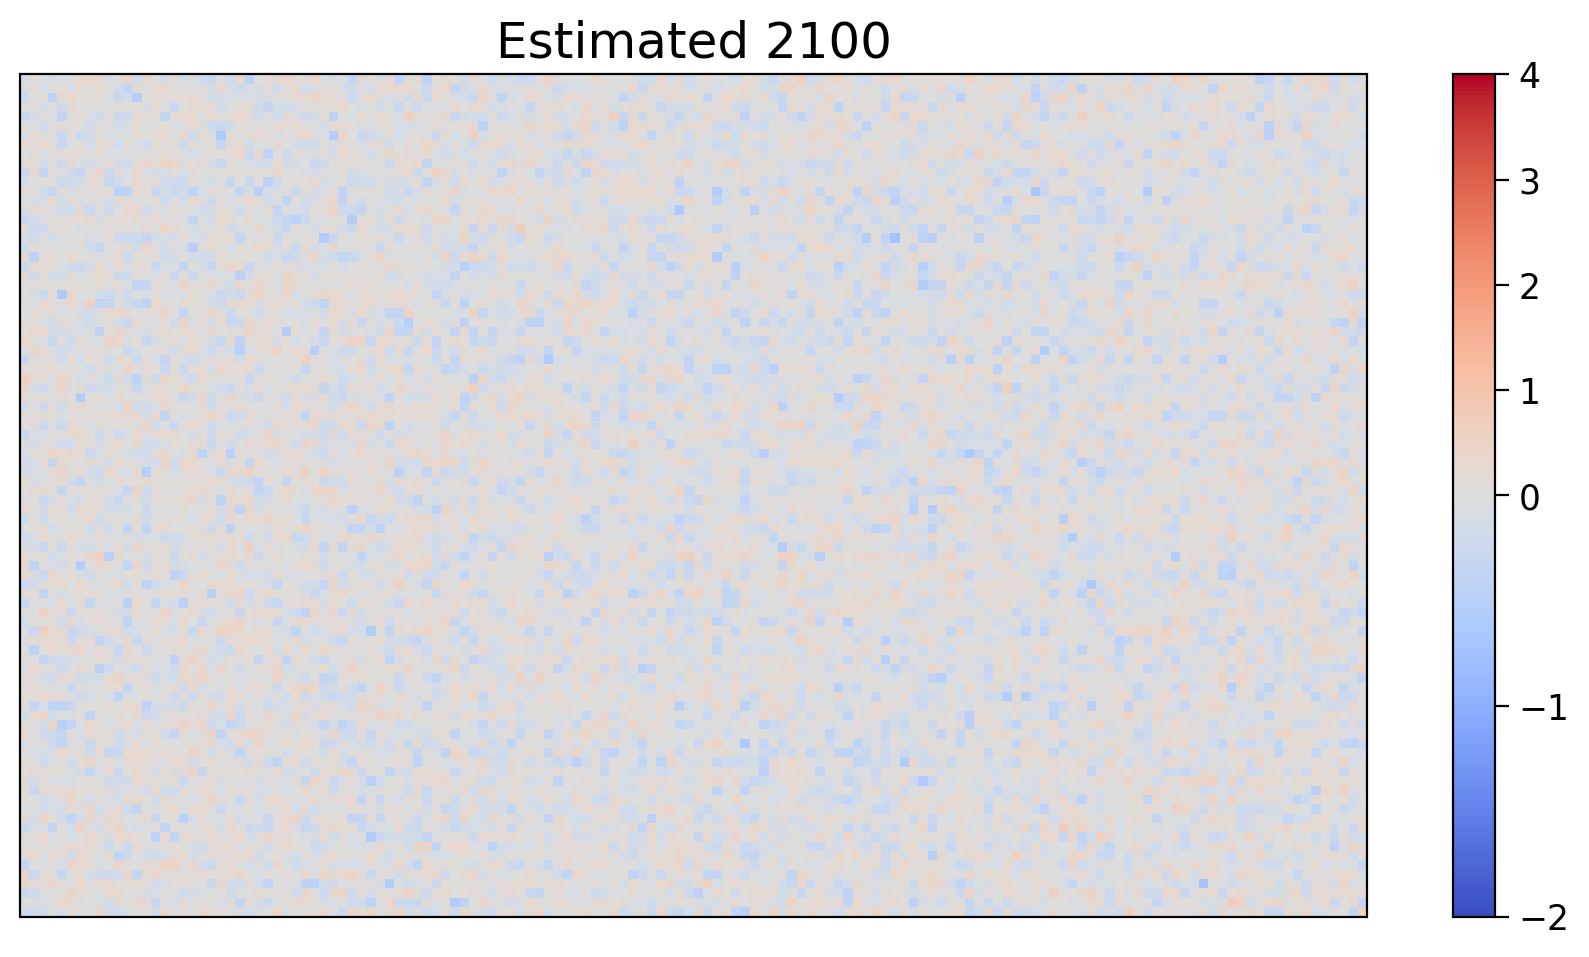

In [61]:
# @title Run this Cell to See the Plot of the Results {"run":"auto","display-mode":"form"}
# Plot results
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=4.)

#the below code sets dummy value to tun th eplots in case the prevous whole cell is commented 
if flag == 0:
    # Dummy prediction: 86 time steps from 2015 to 2100, grid size 96×144 
    
    m_pred = xr.DataArray(
        data=np.zeros((96, 144, 86)),  # [lat, lon, time]
        dims=["lat", "lon", "time"],
        coords={
            "lat": np.linspace(-90, 90, 96),
            "lon": np.linspace(0, 360, 144, endpoint=False),
            "time": np.arange(2015, 2101)
        }
    ).to_dataset(name=var_to_predict)  # Use your default var name if different
    print("\n\n This is just a dummy plot since the cell above is commented out. To see actual predictions, uncomment the code above and rerun this cell.\n\n\n")
else: 
    print("var_to_predict : ",var_to_predict)



for yr in [2020, 2050, 2100]:
    f, axes = plt.subplots(1, 1,
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(9, 5))

    ctr = axes.pcolormesh(m_pred[var_to_predict].sel(time=yr), cmap="coolwarm", norm=divnorm)
    plt.colorbar(ctr)
    axes.set_title(f"Estimated {yr}")

> **Note**: For better predictions, select all scenarios in the *Climate Scenarios* dropdown (Section 2.1.1), then rerun the entire notebook.  
> More training data generally leads to better accuracy.


## Section 10.2 Run Training and Predictions for Each Target Variable from the `test set` of the Climatebench dataset

The section demonstrates how to extend training across multiple target variables (`['tas', 'diurnal_temperature_range', 'pr', 'pr90']`) using the same workflow introduced earlier for single-variable training.


In [62]:
# #Run Training and Predictions for Each Target Variable from the test set of the Climatebench dataset

# #to Load Test Data
# download_test_data()

# # #choose the target variable  by default it is 'tas'  ; uncomment the commented line below for more target vars
# target_vars= ['tas']
# #target_vars= ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

# # #Define the path to the test data
# test_data_path = "Data/test/" 

# # Load and normalize test data
# X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
#                             test_data_path + 'inputs_ssp245.nc']).compute()
# for var in selected_climate_input_vars:
#     X_test[var].data = normalize(X_test[var].data, var, meanstd_inputs)

# X_test_np = input_for_training(X_test, skip_historical=False, len_historical=len_historical)
# X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# # Define the model
# class CNN_LSTM(nn.Module):
#     def __init__(self):
#         super(CNN_LSTM, self).__init__()
#         self.conv = nn.Conv2d(in_channels=4, out_channels=20, kernel_size=3, padding=1)
#         self.pool = nn.AvgPool2d(kernel_size=2)
#         self.lstm = nn.LSTM(input_size=20 * 48 * 72, hidden_size=25, batch_first=True)
#         self.fc = nn.Linear(25, 96 * 144)

#     def forward(self, x):
#         batch_size, seq_len, H, W, C = x.shape  # (batch, time, height, width, channels)

#         # Permute to (batch * time, channels, height, width) for Conv2D
#         x = x.permute(0, 1, 4, 2, 3).contiguous().view(batch_size * seq_len, C, H, W)

#         x = F.relu(self.conv(x))
#         x = self.pool(x)

#         # Reshape for LSTM: (batch, time, features)
#         x = x.view(batch_size, seq_len, -1)

#         x, _ = self.lstm(x)  # LSTM expects (batch, seq, features)
#         x = self.fc(x[:, -1, :])  # Take last timestep output

#         return x.view(-1, 1, 96, 144)  # Reshape to match output shape

# # Training loop
# for var_to_predict in target_vars:
#     print(var_to_predict)

#     # Prepare training data
#     X_train_all = np.concatenate([input_for_training(X_train_norm[i], skip_historical=skip_flags[i], len_historical=len_historical) for i in range(len(scenario_selected))], axis=0)
#     Y_train_all = np.concatenate([output_for_training(Y_train[i], var_to_predict, skip_historical=skip_flags[i], len_historical=len_historical) for i in range(len(scenario_selected))], axis=0)

#     # Convert to PyTorch tensors
#     X_train_tensor = torch.tensor(X_train_all, dtype=torch.float32).to(device)
#     Y_train_tensor = torch.tensor(Y_train_all, dtype=torch.float32).to(device)

#     dataset = TensorDataset(X_train_tensor, Y_train_tensor)
#     dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

#     # Initialize model, loss, and optimizer
#     model = CNN_LSTM().to(device)
#     optimizer = optim.RMSprop(model.parameters(), lr=0.001)
#     criterion = nn.MSELoss()
#     epochs=1 #change this value to atleast 30

#     # Train the model
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0.0
#         for X_batch, Y_batch in dataloader:
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, Y_batch.view(-1, 1, 96, 144))
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

#     # Make predictions
#     model.eval()
#     with torch.no_grad():
#         m_pred = model(X_test_tensor).cpu().numpy()

#     # Reshape to xarray
#     m_pred = xr.DataArray(m_pred[:, 0, :, :], dims=['time', 'lat', 'lon'],
#                           coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
#     xr_prediction = m_pred.transpose('lat', 'lon', 'time').sel(time=slice(2015, 2101)).to_dataset(name=var_to_predict)

#     if var_to_predict in ["pr90", "pr"]:
#         xr_prediction[var_to_predict] /= 86400

#     # Save predictions
#     output_path = data_path + f'outputs_ssp245_predict_{var_to_predict}.nc'
#     #xr_prediction.to_netcdf(output_path, 'w')
#     xr_prediction.close()
#     print(f"Saved {var_to_predict} predictions to {output_path}")

In [63]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_10")

# Section 11: Conclusion

Congratulations! You've successfully built and trained a CNN-LSTM model for climate modeling. You've learned how to load and preprocess climate data, define a CNN-LSTM architecture, train the model with validation and early stopping, and visualize the results.

**Next Steps:**

*   **Experiment with different architectures:** Try changing the number of layers, the kernel sizes, or the number of LSTM units.
*   **Explore different optimizers:** Experiment with different optimization algorithms, such as SGD or RMSProp.
*   **Add more features:** Include additional climate variables as input features.
*   **Evaluate on a larger dataset:** Train and evaluate the model on a larger and more diverse dataset.
*   **Fine-tune hyperparameters:** Use techniques like grid search or random search to find the optimal hyperparameter settings.

This notebook provides a solid foundation for exploring the exciting world of deep learning for climate modeling. Keep experimenting, keep learning, and keep building!

In [64]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_11")

# Summary


In this tutorial, we demonstrated how to apply a `CNN-LSTM` deep learning architecture for climate prediction tasks using spatiotemporal climate datasets. Moving beyond traditional machine learning models, we worked directly with raw NetCDF files from the ClimateBench dataset, preserving spatial (`latitude`, `longitude`) and temporal (`year`) structures.

We implemented the following core steps:

- **Data Preprocessing:** Loaded historical and scenario-based climate variables (`CO₂, CH₄, SO₂, BC`) using `xarray`, applied normalization (`Z-score`), and structured data into overlapping 10-year sliding windows for sequence modeling.

- **Model Design:** Built a hybrid `CNN-LSTM` model in PyTorch. Spatial features were extracted independently at each timestep using TimeDistributed `CNNs`, and temporal dependencies were modeled using an `LSTM`. Final outputs were mapped to gridded climate projections.

- **Data Preparation for Training:** Converted sequences into PyTorch tensors and aligned dimensions to match model input requirements.

This workflow enables learning complex spatiotemporal patterns directly from climate maps, improving long-term climate variable forecasting at the grid level.


# Resources
1. [Neuromatch Deep Learning Course](https://deeplearning.neuromatch.io/tutorials/W1D1_BasicsAndPytorch/student/W1D1_Tutorial1.html)
2. [Climatebench baseline model of CNN-LSTM](https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb)
3. [how-to-work-with-time-distributed-data-in-a-neural-network]( https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00)
4. [Link to the full `ClimateBench` Dataset](https://zenodo.org/records/7064308)